In [3]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib #
from gpflow.utilities import print_summary
import pandas as pd
gpflow.config.set_default_summary_fmt("notebook")
import warnings
import glob
import random
import time
import re
import os, sys
import csv


# The lines below are specific to the notebook format
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

In [4]:
# The global_kernel class is to find GP kernels which are suitable for global stellar parameters (e.g. Teff, Radius) 
#and resample them as a function of the age. 
class seismic_1d_kernel:
    '''
    The global_kernel class aims to find an proper and efficient GP kernel for a global parameter (e. g. Teff) for
    the whole grid.  
    '''
    
    def __init__(self, datapath = None, savepath = None):
        return None
    
    def set_path(self, datapath = None, savepath = None):
        self._datapath = datapath
        self._savepath = savepath
        
        if not os.path.exists(datapath):
            raise Warning(f'datapath:' + datapath + ' does not exist')
        
        if not os.path.exists(savepath): os.makedirs(savepath)
        
        print('Data path is set as' + self._datapath)
        print('Save path is set as' + self._savepath)
        return self
    
    def preview_1d_data(self, condition = None, number = None,
                        x = None, y = None, 
                        x2 = None, xlog = None, ylog = None, 
                        xnormalization = None, ynormalization = None,
                        savefig = None):
        
        print('ynormalization', ynormalization)
        
        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if number == None:
            warnings.warn(f'$number$ is missing, 1 file will be used', UserWarning)
            number = 1
            
        if (x == None) or (y == None) or (type(x) != str) or (type(y) != str): 
            raise Warning(f'$X$ and $Y$ must be given with the type of string')
    
        all_files = glob.glob(self._datapath + condition)
        random.shuffle(all_files)
        n = min([int(number), len(all_files)])
        files= all_files[0:n]
        
        plt.figure(figsize=(12, 6))
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title('Preview of ' + x + ' vs ' + y)
        for filename in files:
            print(filename)
            gpx, gpy, gpx_v, gpy_v, xrange, yrange = self.get_data_of_a_track(filename, x, y, x2, xlog, ylog, xnormalization, ynormalization, fraction = 0.9)
            plt.plot(gpx, gpy, 'k.', mew=1)
            plt.plot(gpx, gpy, 'r')
        if (savefig == True): plt.savefig(self._savepath + 'S00_' + x + '_vs_' + y + 'preview.png')
        return None
    
    def kernel_bank(self, kname = None):
        #basic kernels
        
        variance=1.0
        lengthscale = 10.0
        
        if kname == 'constant': k = gpflow.kernels.Constant(variance=variance, active_dims=None)
        if kname == 'linear': k = gpflow.kernels.Linear(variance=variance, active_dims=None)
        if kname == 'poly2': k = gpflow.kernels.Polynomial(degree=2.0, variance=variance, offset=lengthscale, active_dims=None)
        if kname == 'poly3': k = gpflow.kernels.Polynomial(degree=3.0, variance=variance, offset=lengthscale, active_dims=None)
        if kname == 'poly4': k = gpflow.kernels.Polynomial(degree=4.0, variance=variance, offset=lengthscale, active_dims=None)
        if kname == 'poly5': k = gpflow.kernels.Polynomial(degree=3.0, variance=variance, offset=lengthscale, active_dims=None)
        if kname == 'poly6': k = gpflow.kernels.Polynomial(degree=4.0, variance=variance, offset=lengthscale, active_dims=None)
        if kname == 'cosine': k = gpflow.kernels.Cosine(variance=variance, lengthscale=lengthscale)
        if kname == 'arccosine': k = gpflow.kernels.ArcCosine(order=0, variance=variance, weight_variances=lengthscale, bias_variance=variance, active_dims=None)
        if kname == 'exponential': k = gpflow.kernels.Exponential(variance=variance, lengthscale=lengthscale)# f = ab^x

        #The periodic family of kernels. 
        if kname == 'periodic': k = gpflow.kernels.Periodic(period=1.0)

        #The radial basis function or squared exponential kernel
        if kname == 'se': k = gpflow.kernels.SquaredExponential(variance=variance, lengthscale=lengthscale)
        #Rational Quadratic kernel: adding together many se(rbf) kernels with different lengthscales
        if kname == 'rq': k = gpflow.kernels.RationalQuadratic(variance=variance, lengthscale=lengthscale, alpha=1.0, active_dims=None)

        #The Matern 1/2 kernel. Functions drawn from a GP with this kernel are not differentiable anywhere.
        if kname == 'matern12': k = gpflow.kernels.Matern12(variance=variance, lengthscale=lengthscale)
        #The Matern 3/2 kernel. Functions drawn from a GP with this kernel are once differentiable.
        if kname == 'matern32': k = gpflow.kernels.Matern32(variance=variance, lengthscale=lengthscale)
        #The Matern 5/2 kernel. Functions drawn from a GP with this kernel are twice differentiable. 
        if kname == 'matern52': k = gpflow.kernels.Matern52(variance=variance, lengthscale=lengthscale)

        #Kernels who don’t depend on the value of the inputs are ‘Static’. The only parameter is a variance, σ².
        if kname == 'static': k = gpflow.kernels.Static(variance=variance, active_dims=None)
        #The White kernel: this kernel produces ‘white noise’
        if kname == 'white': k = gpflow.kernels.White(variance=variance, active_dims=None)
        return k
    
    def standard_kernel_box(self):
        kernels = ['constant','linear','poly2','poly3', 'poly4','cosine','arccosine',
                   'exponential', 'periodic', 'se', 'rq', 
                   'matern12', 'matern32', 'matern52']
        return kernels
    
    def solve_kernel_combinations(self, kname = None):
        
        #get a kernel list
        words = re.split('\s',kname)
        kkk = re.split('[+]|[-]|[*]|[/]', kname)
        
        #print(words)
        #print(kkk)
        
        karr = []
        
        #find a kernels_array
        for word in words: 
            if ( (word != '+') & (word != '-') & (word != '*') & (word != '/')):
                get_kernel = self.kernel_bank(word)
            else:
                get_kernel = None
            
            karr = karr + [get_kernel]
        
        #print(karr)
        
        #get a str to describ the kernel
        kernels_str = ''
        for iw in range(len(words)):
            if ( (words[iw] != '+') & (words[iw] != '-') & 
                (words[iw] != '*') & (words[iw] != '/')):
                kernels_str = kernels_str + 'karr[' + str(iw) + ']'
            else:
                kernels_str = kernels_str + words[iw]
            
            #print(kernels_str)
        
        kernels = eval(kernels_str)
        
        #print(kernels)
        
        return kernels
    
    #############################################################################################################
    ################Change this function for different data formats##############################################
    #############################################################################################################
    def get_data_of_a_track(self, filename = None, x = None, y = None, 
                            x2 = None, xlog = None, ylog = None, 
                            xnormalization = None, ynormalization = None, 
                            fraction = None, random_state = None):
        '''
        To split a track into two subssets for training and testing with a given fraction. 
        The training set has an maxmum number of 1000. 
        outputs:
        training set: gpx, gpy,
        testing set: gpx_v, gpy_v
        '''
        
        nu_max_col = 'nu_max'
        nu_range = [0.4, 1.6]
        
        one_track = []
        one_track = pd.read_csv(filename)
        #get rid of the pre-MS
        one_track = one_track.loc[one_track['center_h1'] <= 0.997*np.max(one_track['center_h1']) ]
        
        one_track = one_track[[x,y,nu_max_col]]
        
        one_track = one_track[(one_track[y] >= nu_range[0]*one_track[nu_max_col]) &
                              (one_track[y] <= nu_range[1]*one_track[nu_max_col]) &
                              (one_track[y] > 0.0)
                             ]
        
        #if (x == 'star_age'): one_track[x] = one_track[x]/1.0e9
        if (x2 == True): one_track[x] = np.square(one_track[x]) #one_track[x]*10.0 #
        one_track[x] = np.log10(one_track[x])
        one_track[y] = np.log10(one_track[y])
        one_track = one_track.replace([np.inf, -np.inf], np.nan)
        one_track.isna().sum()
        one_track = one_track.dropna()
        
        if (xlog != True): one_track[x] = 10.0**(one_track[x])
        if (ylog != True): one_track[y] = 10.0**(one_track[y])
        
        yrange = [np.min(one_track[y]), np.max(one_track[y])]
        xrange = [np.min(one_track[x]), np.max(one_track[x])]
        
        if (ynormalization == True): 
            one_track[y] = (one_track[y] - min(yrange))/(max(yrange) - min(yrange))
        
        if (xnormalization == True): 
            one_track[x] = (one_track[x] - min(xrange))/(max(xrange) - min(xrange))            
        
        if (random_state == None): random_state = 0
        
        if (len(one_track[x])*fraction >= 1000):
            train = one_track.sample( n = 1000, random_state=random_state) #random state is a seed value
        else:
            train = one_track.sample(frac = fraction, random_state=random_state) #random state is a seed value
        train = train.sort_index()
        test = one_track.drop(train.index)
        test = test.sort_index()
        
        gpx = train[x].to_numpy().reshape(-1, 1)
        gpy = train[y].to_numpy().reshape(-1, 1)
        gpx = np.float64(gpx)
        gpy = np.float64(gpy)
        
        gpx_v = test[x].to_numpy().reshape(-1, 1)
        gpy_v = test[y].to_numpy().reshape(-1, 1)
        gpx_v = np.float64(gpx_v)
        gpy_v = np.float64(gpy_v)
        return gpx, gpy, gpx_v, gpy_v, xrange, yrange
    #############################################################################################################
    

    
    def opt(self, filename = None, x = None, y = None, x2 = None, xlog =None, ylog = None, 
            xnormalization = None, ynormalization = None, fraction = None, 
            gpk = None, kname = None, iterations = None, figures = None, printinfo = None):
        '''
        optimize model
        '''
        opt = gpflow.optimizers.Scipy()
        
        flag = False
        def objective_closure():
            return -m.log_marginal_likelihood()
        
        fail = 0
        for i in range(iterations):
            gpx, gpy, gpx_v, gpy_v, xrange, yrange = self.get_data_of_a_track(filename, x, y, x2, xlog, ylog,
                                                                              xnormalization, ynormalization,
                                                                              fraction = fraction, 
                                                                              random_state = random.randint(0,200))
            
            m = gpflow.models.GPR(data=(gpx, gpy), kernel=gpk, mean_function=None)
            
            if ((gpx.size <= 5) or (gpx_v.size <=2)):
                offset2 = [-9999.0]
                mean, var, mean_v, var_v = [-9999.0, -9999,-9999,-9999]
                break            
            
            try:
                opt_logs = opt.minimize(objective_closure, 
                                        m.trainable_variables, 
                                        options=dict(maxiter=1000))
                #print_summary(m, fmt = "notebook")
            except:
                fail = fail + 1
                offset2 = [-9999.0]
                mean, var, mean_v, var_v = [-9999.0, -9999,-9999,-9999]
            else:
                offset2, mean, var, mean_v, var_v = self.predict(gpx, gpy, gpx_v, gpy_v, m, kname, figures)
                if (printinfo == True):
                    print('GP is done with ' + kname + ' for ' + filename)
                    print('kernel, mean offset^2')
                    print(kname, np.mean(offset2))
                break
        if (fail < iterations):
            if (printinfo == True): print(str(fail) + ' times iterations with ' + kname)
        else:
            if (printinfo == True): print('iteration excceds with ' + kname+ ' for ' + filename)
        #print('------------------------------------------------')
        return m, np.mean(offset2), mean, var, mean_v, var_v, gpx, gpy, gpx_v, gpy_v, xrange, yrange 
    
    def predict(self, gpx = None, gpy = None, gpx_v = None, 
                gpy_v = None, m = None, kname = None, figures = None):
        ## generate test points for prediction
        gpx_v = gpx_v  # test points must be of shape (N, D)

        ## predict mean and variance of latent GP at test points
        mean, var = m.predict_f(gpx)
        mean_v, var_v = m.predict_f(gpx_v)
        offset = (gpy_v - mean_v)**2.0
        
        return offset, mean, var, mean_v, var_v

    #----------------------------
    def find_1d_kernel(self, condition = None, subset_fraction = None, 
                       x = None, y = None, x2 = None, xlog = None, ylog = None, 
                       xnormalization = None, ynormalization = None,
                       kernels = None, kernel_combinations = None,
                       iterations = None, validation_frac = None,
                       printinfo = None, figures =None):
        
        '''
        find_1d_kernel is to test which is the best kernel works for the data. The function uses a subset
        of the grid and GP those data with potential kernels and validate GP models. 
        The function return a pandas.dataframce which gives the mean of deviation square in the validation. 
        '''
        
        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if subset_fraction == None:
            warnings.warn(f'$subset_fraction$ is missing, all files will be used', UserWarning)
            subset_fraction = 1.0
            
        if (x == None) or (y == None) or (type(x) != str) or (type(y) != str): 
            raise Warning(f'$X$ and $Y$ must be given with the type of string')
            
        if ((kernels == None) & (kernel_combinations == None)): 
            warnings.warn(f'$kernels$ is missing, standard kernel box will be used', UserWarning)
            kernels = self.standard_kernel_box()
        
        if (validation_frac == None) or (validation_frac >=1.0):
            warnings.warn(f'incorrect $validate_fraction$, default value validate_fraction = 0.2 will be set', UserWarning)
            fraction = 1.0 - 0.2
        else:
            fraction = 1.0 - validation_frac
        
        print('Initial guesses of kernels are:')
        if (kernel_combinations == None): 
            print(kernels)
        else: 
            print([kernels] + [kernel_combinations])
            
        all_files = glob.glob(self._datapath + condition)
        random.shuffle(all_files)
        
        nuse = max([int(subset_fraction*len(all_files)), 1])
        
        files= all_files[0:nuse]
        print( str(nuse) + '/' + str(len(all_files)) + 'tracks are used.' )
            
        df_c = []    
        #working on kernels
        if (kernels != None):
            offset_array = np.full((len(files), len(kernels)), -9999.0)
            for ik in range(len(kernels)):
                kname = kernels[ik]
                gpk = self.kernel_bank(kname = kname)
            
                print('working on kernel: ' + kname + '(' + str(ik+1) + '/' + str(len(kernels)) + ')' )
            
                if (figures == True): 
                    fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize = (15,10))
            
                for ifile in range(len(files)):
                    gpm, offset_array[ifile, ik],\
                    mean, var, mean_v, var_v, \
                    gpx, gpy, gpx_v, gpy_v, \
                    xrange, yrange = \
                    self.opt(files[ifile], x, y, x2, xlog, ylog, \
                             xnormalization, ynormalization, fraction, gpk, kname, iterations, figures, printinfo)
                
                    if ((figures == True) & (offset_array[ifile, ik] >= -99.0)): 
                    # generate 10 samples from posterior
                        #samples = gpm.predict_f_samples(gpx, 10)  # shape (10, 100, 1)           
                        ax1.plot(gpx, gpy, 'k')
                        ax1.errorbar(gpx, mean, yerr = var,c ='C0', lw=2)
                        ax1.fill_between(gpx[:,0], 
                                         mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                                         mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                                         color='C0', alpha=0.2)
                        #ax1.plot(gpx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)

                        ax2.scatter(gpx_v, gpy_v,c = 'b', s = 0.5)
                        ax2.plot(gpx_v, mean_v ,c ='r')
                        
                        res = gpy_v - mean_v
                        ax3.scatter(gpx_v, res, c = 'r', s = 1.0)
                        ax3.errorbar(gpx, (gpy-gpy), yerr = var,c ='b', lw=1)
                        ax3.set_ylim([np.min(res), np.max(res)])
                        ax3.set_xlabel(x)
                        ax3.set_ylabel('redidual (validated models - GP)')
                if (figures == True):
                    arr = offset_array[:,ik]
                    arr = arr[arr > -9990.0]
                    fig.suptitle(kname + ', d=' + str(np.mean(arr)))
                    plt.savefig(self._savepath + 'S03'+ kname + 'fit.png')
            kernels_df = pd.DataFrame(data = offset_array, columns=kernels)
            df_c = df_c + [kernels_df]
        
        kernel_combinations_df = []
        #working on kernel_combinations
        if (kernel_combinations != None):
            offset_array = np.full((len(files), len(kernel_combinations)), -9999.0)
            for ik in range(len(kernel_combinations)):
                kname = kernel_combinations[ik]
                gpk = self.solve_kernel_combinations(kname = kname)
                
                print('working on kernel combinations: ' + kname + '(' + str(ik+1) + '/' + str(len(kernel_combinations)) + ')' )
            
                if (figures == True): 
                    fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize = (15,10))
            
                for ifile in range(len(files)):
                    gpm, offset_array[ifile, ik],\
                    mean, var, mean_v, var_v, \
                    gpx, gpy, gpx_v, gpy_v, \
                    xrange, yrange = \
                    self.opt(files[ifile], x, y, x2, xlog, ylog, \
                             xnormalization, ynormalization, 0.5, gpk, kname, iterations, figures, printinfo)
                
                    if ((figures == True) & (offset_array[ifile, ik] >= -99.0)): 
                    # generate 10 samples from posterior
                        #samples = gpm.predict_f_samples(gpx, 10)  # shape (10, 100, 1)           
                        ax1.plot(gpx, gpy, 'k')
                        ax1.errorbar(gpx, mean, yerr = var,c ='C0', lw=2)
                        ax1.fill_between(gpx[:,0], 
                                         mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                                         mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                                         color='C0', alpha=0.2)
                        #ax1.plot(gpx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)

                        ax2.scatter(gpx_v, gpy_v,c = 'b', s = 0.5)
                        ax2.plot(gpx_v, mean_v ,c ='r')
                        
                        ax3.scatter(gpx_v, gpy_v - mean_v, c = 'r', s = 1.0)
                        ax3.errorbar(gpx, (gpy-gpy), yerr = var,c ='b', lw=1)
                        ax3.set_xlabel(x)
                        ax3.set_ylabel('redidual (validated models - GP)')
                if (figures == True):
                    arr = offset_array[:,ik]
                    arr = arr[arr > -9990.0]
                    fig.suptitle(kname + ', d=' + str(np.mean(arr)))
                    plt.savefig(self._savepath + 'S03' + kname + 'fit.png')
            kernel_combinations_df = pd.DataFrame(data = offset_array, columns=kernel_combinations)
            df_c = df_c + [kernel_combinations_df]

        df = pd.concat(df_c, axis=1)        
        return df
    
    ###########
    def apply_1d_kernel(self, condition = None,x = None, y = None, x2 = None, xlog = None, ylog = None,
                        xnormalization = None, ynormalization = None, validation_frac = None,
                        kernels = None, combination = None,
                        iterations = None,
                        savemodelprefix = None,
                        printinfo = None, figures = None,
                        savetablename = None):
        
        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
      
        if (x == None) or (y == None) or (type(x) != str) or (type(y) != str): 
            raise Warning(f'$X$ and $Y$ must be given with the type of string')
            
        if ((validation_frac == None) or (validation_frac >=1.0)):
            warnings.warn(f'$svalidation_frac$ is missing, validation_frac = 0.2 will be used', UserWarning)
            validation_frac = 0.2
        
        train_frac = 1 - validation_frac
            
        if (kernels == None):
            raise Warning(f'$kernels$ must be given', UserWarning)
       
        if(len(kernels) > 1): 
            raise Warning(f'Only one $kernels$ should be given', UserWarning)
            
        if (iterations == None):
            warnings.warn(f'$iterations$ is missing, iterations = 10 will be used', UserWarning)
            iterations = 10
        
        if (savemodelprefix == None):
            warnings.warn(f'$savemodelprefix$ is missing, savemodelprefix = y will be used', UserWarning)
            savemodelprefix = y
        
        ###########get all files in datapath
        files = glob.glob(self._datapath + condition)
        random.shuffle(files)
        print(str(len(files)) + ' files are found in ' +  self._datapath + ' with the condition ' + condition)
    
        offset_array = np.full(len(files), -9999.0)
    
        ###### mkdir for figures
        if (figures == True): 
            fig_directory = self._savepath + savemodelprefix + 'figures/'
            if not os.path.exists(fig_directory):
                os.makedirs(fig_directory)
        
        dict_directory = self._savepath + savemodelprefix + 'dicts/'
        if not os.path.exists(dict_directory):
            os.makedirs(dict_directory)        
                
        ######### solve kernel
        
        kname = kernels[0]
        
        if (combination ==True):
            gpk = self.solve_kernel_combinations(kname = kname)
        else:
            gpk = self.kernel_bank(kname = kname)
            
        df = []
        
        df = pd.DataFrame(columns=['evolutionary_track', 'x', 'y', 'x2','xlog', 'ylog', 
                                   'xrange', 'yrange', 'xnormalization', 'ynormalization',
                                   'kname', 'combination',
                                   'mean_deviation', 'max_deviation', 'saveGPmodel', 'saveGPdata'])
        
        ########get gp models for tracks
        for ifile in range(len(files)):
                    gpm, offset_array[ifile],\
                    mean, var, mean_v, var_v, \
                    gpx, gpy, gpx_v, gpy_v, \
                    xrange, yrange = \
                    self.opt(files[ifile], x, y, x2,xlog, ylog, xnormalization, ynormalization, train_frac, gpk, kname, iterations, figures, printinfo)
                    
                    temp = re.search(self._datapath + '(.+?).csv', files[ifile])
                    trackname = temp.group(1)                    
                    
                    savedictname = dict_directory + trackname + '.gpdict'                    
                    self.save_1d_gpdict(gpm = gpm, savedictname = savedictname)
                    
                    res = gpy_v - mean_v.numpy()
                    savedataname = dict_directory + trackname + '.gpdata'
                    self.save_1d_gpdata(gpx, gpy, gpx_v, gpy_v, res, savedataname = savedataname)
                    
                    mean_deviation = np.mean(np.abs(res))
                    
                    #to have a reasonable max_deviation 
                    #we removed the points closed to both edges
                    
                    max_deviation = np.max(np.abs(res[2: (len(res) - 2)]))
                    
                    df.loc[ifile] = [trackname, x, y,x2, xlog, ylog,
                                     str(xrange), str(yrange),
                                     xnormalization, ynormalization,
                                     kname,combination,
                                     mean_deviation, max_deviation,
                                     trackname + '.gpdict',
                                     trackname + '.gpdata'
                                    ]
                    
                    if ((figures == True) & (offset_array[ifile] >= -99.0)): 
                        fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize = (15,10))
                        ax1.plot(gpx, gpy, 'k')
                        ax1.errorbar(gpx, mean, yerr = var,c ='C0', lw=2)
                        ax1.fill_between(gpx[:,0], 
                                         mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                                         mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                                         color='C0', alpha=0.2)
                        ax1.set_ylabel(y)

                        ax2.scatter(gpx_v, gpy_v,c = 'b', s = 1.0)
                        ax2.plot(gpx_v, mean_v ,c ='r')
                        ax2.set_ylabel(y)
                        
                        res = gpy_v - mean_v
                        ax3.scatter(gpx_v, res, c = 'r', s = 1.0)
                        ax3.errorbar(gpx, (gpy-gpy), yerr = var,c ='b', lw=1)
                        ax3.set_ylim([np.min(res), np.max(res)])
                        ax3.set_xlabel(x)
                        ax3.set_ylabel('residual (validated models - GP)')
                        
                        fig.suptitle(kname + ', d=' + str(offset_array[ifile]))
                        plt.savefig(fig_directory + trackname + '.png')
        
        if (savetablename != None):
            df.to_csv(self._savepath + savemodelprefix + savetablename)
        
        return df
    
    
    def save_1d_gpdata(self, gpx = None, gpy = None, gpx_v = None, gpy_v = None, 
                       res = None, savedataname = None):
        
        wd = csv.writer(open(savedataname, "w"))
        wd.writerow(['gpx','gpy','type','offset'])
        for ii in range(len(gpx)):
            wd.writerow([gpx[ii][0], gpy[ii][0], 'data', -9999.0])
        for iv in range(len(gpx_v)):
            wd.writerow([gpx_v[iv][0], gpy_v[iv][0], 'vali', res[iv][0]])
        return
    
    
    def save_1d_gpdict(self, gpm = None, savedictname = None):
        gpdict = gpflow.utilities.parameter_dict(gpm)
        ww = csv.writer(open(savedictname, "w"))
        ww.writerow(['name','shape','dtype','value'])
        for name, var in gpdict.items():
            ww.writerow([name,var.shape.ndims, var.dtype.name, var.numpy()])
        return
    
    ####################Now we can use model to predict#######################
    def load_gp_bank(self, tablename = None, dtype = None, gpdictpath = None, gpdatapath = None):
        
        if not os.path.exists(gpdictpath):
            raise Warning(f'datapath:' + gpdictpath + ' does not exist')
        if not os.path.exists(gpdatapath):
            raise Warning(f'datapath:' + gpdatapath + ' does not exist')
            
        gptable = pd.read_csv(tablename, dtype=dtype, index_col = 0)
        
        self._gpdictpath = gpdictpath
        self._gpdatapath = gpdatapath
        
        return gptable
    
    def use_gp_model(self, model_dict = None, model_data = None,
                     x = None, y = None, x2 = None, xlog = None, ylog = None,
                     xrange = None, yrange = None, 
                     xnormalization = None, ynormalization = None, 
                     kernels = None, combination = None, 
                     x_input = None):
        
        x_input_scaled = x_input
        
        if (x2 == True): x_input_scaled = np.square(x_input_scaled)
        if (xlog == True): x_input_scaled = np.log10(x_input_scaled)
        
        print('Note that only x_input within xrange will be calculated')
                
        x_input_scaled = x_input_scaled[((x_input_scaled >= min(xrange)) & (x_input_scaled <= max(xrange)))]
        
        if (x_input_scaled.size ==0): 
            raise Warning(f'No x_input value is on the track')
        
        if (xnormalization == True): 
            x_input_scaled = (x_input_scaled - min(xrange))/(max(xrange) - min(xrange))
        
        x_input_scaled = x_input_scaled.reshape(-1,1)
                    
        print(self._gpdictpath + model_dict)
        mdf = pd.read_csv(self._gpdictpath + model_dict)
        new_dict = {}
        for i in range( len(mdf['name']) ):
            if mdf['shape'][i] == 0: shape = ()
            tfvar = tf.Variable(mdf['value'][i], shape = shape, dtype= mdf['dtype'][i])
            gpvar = gpflow.base.Parameter(tfvar)
            new_dict[mdf['name'][i]] = gpvar
        
        if (combination == True):
            gpk = self.solve_kernel_combinations(kname = kernels[0])
        else:
            gpk = self.kernel_bank(kname = kernels[0])
        
        gpx, gpy, gpx_v, gpy_v, gpy_v_d = self.load_gp_data(self._gpdatapath + model_data) 
        
        gpm = gpflow.models.GPR(data=(gpx, gpy), kernel=gpk, mean_function=None)
        gpflow.utilities.multiple_assign(gpm, new_dict)
        
        
        predictions, predictions_var = gpm.predict_f(x_input_scaled)
        predictions_err = x_input_scaled*0.0
        
        predictions_err = np.interp(x_input_scaled, gpx_v.reshape(len(gpx_v),), gpy_v_d.reshape(len(gpy_v_d)))
        
        ####inverse normalization###########
        def inverse_scale(p = None, prange = None, normalization = None, log=None, p2 = None):
            
            if (normalization == True): p = p*(max(prange) - min(prange)) + min(prange)
            if (log == True): p = 10.0**p
            if (p2 == True): p = p**0.5
            return p
        
        
        track_x = inverse_scale(gpx, xrange, xnormalization, xlog, x2)
        track_x_v = inverse_scale(gpx_v, xrange, xnormalization, xlog, x2)
        track_y = inverse_scale(gpy, yrange, ynormalization, ylog)
        track_y_v = inverse_scale(gpy_v, yrange, ynormalization, ylog) 
        new_x = inverse_scale(x_input_scaled, xrange, xnormalization, xlog, x2)
        new_y = inverse_scale(predictions, yrange, ynormalization, ylog)
        
        def inverse_dif(p = None, dif = None, prange = None, normalization = None, log=None, p2 = None):
            ppd = p + dif
            pnew = inverse_scale(p, prange, normalization, log, p2)
            ppdnew = inverse_scale(ppd, prange, normalization, log, p2)     
            return ppdnew - pnew
        
        track_y_v_e = inverse_dif(gpy_v, gpy_v_d, yrange, ynormalization, ylog)
        new_y_e = inverse_dif(predictions, predictions_err, yrange, ynormalization, ylog)
       ######inverse normalization end######
        
        return track_x, track_y, track_x_v, track_y_v, track_y_v_e, new_x, new_y, new_y_e
    
    def load_gp_data(self, filename):
        mdd = pd.read_csv(filename)
            
        gpx = mdd['gpx'].loc[mdd['type'] == 'data']
        gpx = gpx.to_numpy().reshape(-1, 1)
        gpx = np.float64(gpx)
        
        gpy = mdd['gpy'].loc[mdd['type'] == 'data']
        gpy = gpy.to_numpy().reshape(-1, 1)
        gpy = np.float64(gpy)
            
        gpx_v = mdd['gpx'].loc[mdd['type'] == 'vali']
        gpx_v = gpx_v.to_numpy().reshape(-1, 1)
        gpx_v = np.float64(gpx_v)      
            
        gpy_v = mdd['gpy'].loc[mdd['type'] == 'vali']
        gpy_v = gpy_v.to_numpy().reshape(-1, 1)
        gpy_v = np.float64(gpy_v)
            
        gpy_v_d = mdd['offset'].loc[mdd['type'] == 'vali']
        gpy_v_d = gpy_v_d.to_numpy().reshape(-1, 1)
        gpy_v_d = np.float64(gpy_v_d) 
            
        return gpx, gpy, gpx_v, gpy_v, gpy_v_d



# global_kernel 

The global_kernel class is to find proper GP kernels for global stellar parameters (e.g. Teff, Radius) and resample them as a function of the age. 

A recomended step-by-step procudure for a stellar parameter is: 
1. 'global_kernel.preview_1d_data'：preview data with to see which kernels could be used;  
2. 'global_kernel.generate_kernel_grid' or manually: set up a list of kernels 
3. 'global_kernel.find_1d_kernel': find the best kernel for a certain parameter with a random selected subset in the grid
4. 'global_kernel.gpmodel': use the kernel found in step 3 and obtain one gp model for each global parameter on each track (as a function of stellar age) 
5. 'global_kernel.resample': resample each evolutaionary track  


# step 1 preview data
The purpose of vasual inspection is find out which kernals may work for the parameter. The effective temperature is the most tricky parameter. Because the curve changes sharply with age at the beginning and the ending parts (pre-MS and giant phases) and is spiky at the turn-off points.

In [19]:
datadr = '/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/'
savedr = '/Users/litz/Documents/GitHub/GPflow/nu_1_-10/'

In [20]:
gk = seismic_1d_kernel()
gk.set_path(datapath = datadr, savepath = savedr)

Data path is set as/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/
Save path is set as/Users/litz/Documents/GitHub/GPflow/nu_1_-10/


# step 1 preview data
The purpose of vasual inspection is find out which kernals may work for the parameter.
The effective temperature is the most tricky parameter. Because the curve changes sharply with age at the beginning and the ending parts (pre-MS and giant phases) and is spiky at the turn-off points. 

ynormalization True
/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/m1.34_feh4.0_MLT1.9_fov0.018.csv


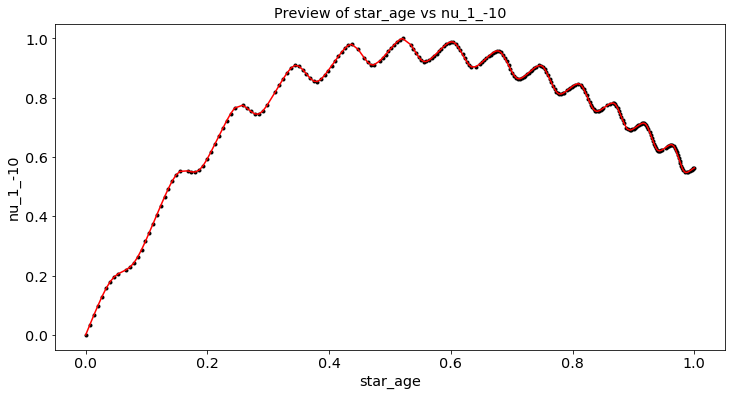

In [29]:
gk.preview_1d_data(condition = '*.csv', number = 1,
                   x = 'star_age', y = 'nu_1_-10', 
                   x2 = False, xlog = False, ylog = False, 
                   xnormalization = True, ynormalization = True,
                   savefig = True)

# Step2 make initial guess of the kernel

individual kernel names are: ['constant','linear','poly2','poly3', 'poly4', 'poly5', 'poly6','cosine','arccosine', 'exponential', 'periodic', 'se', 'rq', 'matern12', 'matern32', 'matern52','static','white']

kernel combinations are also available. Three notes: 1) kernel names and math symbols MUST be seperated by spaces, e.g. 'constant + linear * poly2'; 2) combinations with + - * / are surpported; 3) do not use parentheses or brackets. For the case like '(se + poly3) * linear', please use 'se * linear + ploy3 * linear'

Examples:

kernels =  ['poly3', 'poly4', 'se', 'rq', 'matern12', 'matern32', 'matern52']

kernel_combinations = ['constant + se', 'se + matern12', 'constant + poly3 + se', 'constant + poly3 + rq', 'linear * linear + se'] 

In [31]:
datadr = '/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/'
savedr = '/Users/litz/Documents/GitHub/GPflow/nu_1_-10/test1/'

gk = seismic_1d_kernel()
gk.set_path(datapath = datadr, savepath = savedr)

Data path is set as/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/
Save path is set as/Users/litz/Documents/GitHub/GPflow/nu_1_-10/test1/


In [32]:
kernels = ['poly6', 'se', 'rq', 'matern32', 'matern52']
kernel_combinations = [
                       'se + linear',
                       'rq + linear',
                       'se + poly6',
                       'rq + poly6',
                       'se + matern32',
                       'rq + matern32',
                       'matern32 + linear',
                       'se + se',
                       'rq + rq'
                      ]

We could also check kernel functions with following codes


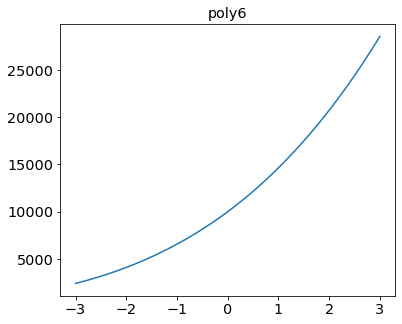

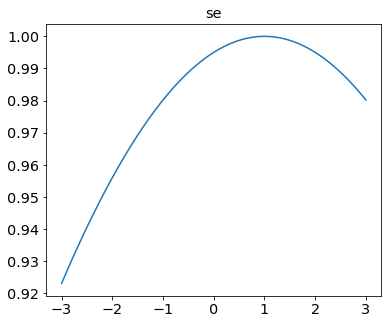

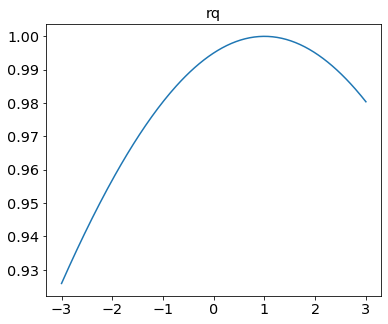

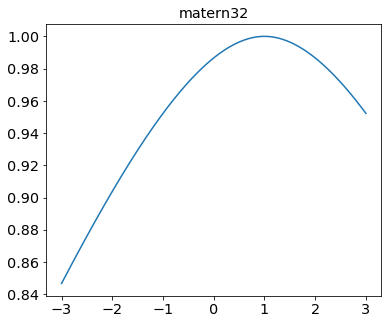

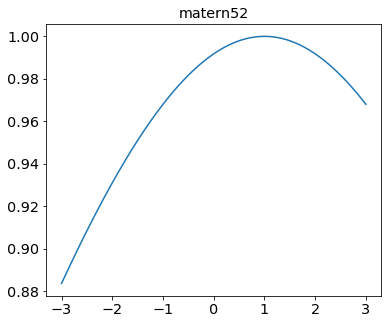

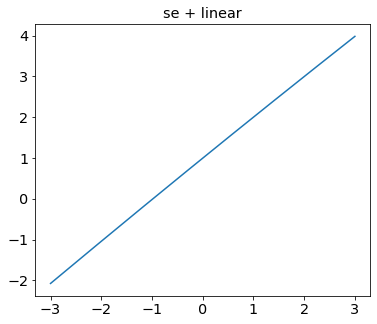

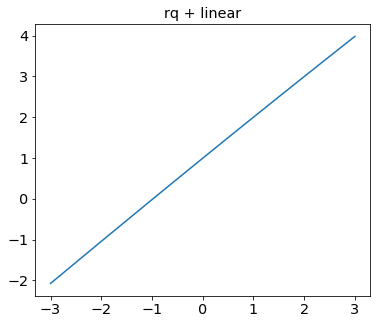

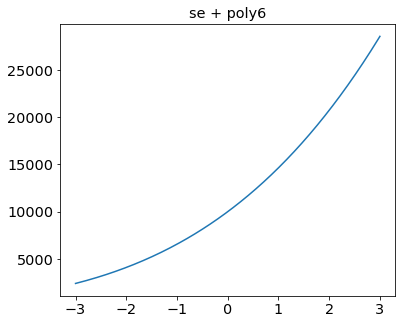

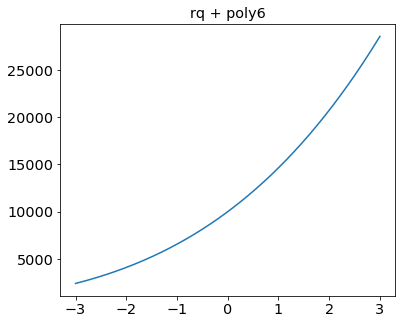

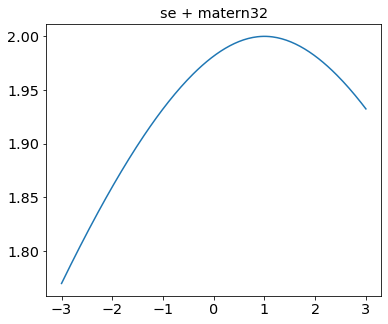

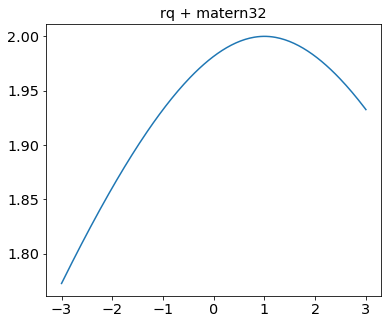

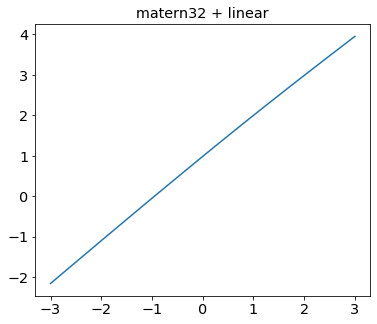

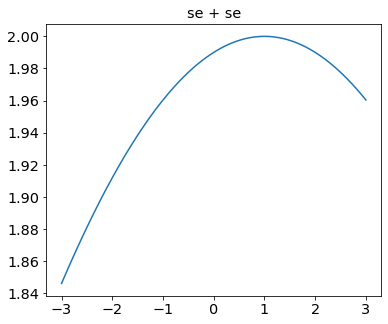

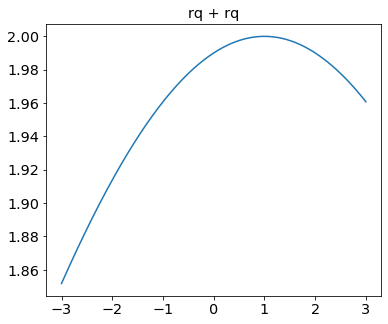

In [43]:
def plotkernelfunction(k = None, ax = None, xmin=None, xmax=None, other=None, kname = None):
    xx = np.linspace(xmin, xmax, 200)[:,None]
    ax.plot(xx, k(xx, np.zeros((1,1)) + other))
    ax.set_title(kname)

for kname in kernels:
    kernel = gk.kernel_bank(kname)
    f, axes = plt.subplots(1, 1, figsize=(6, 5), sharex=True)
    plotkernelfunction(k = kernel, ax = axes, xmin=-3, xmax=3, other=1.0, kname = kname)
    
for kname in kernel_combinations:
    kernel = gk.solve_kernel_combinations(kname)
    f, axes = plt.subplots(1, 1, figsize=(6, 5), sharex=True)
    plotkernelfunction(k = kernel, ax = axes, xmin=-3, xmax=3, other=1.0, kname = kname)

# Step 3 use a subset to test kernels

Initial guesses of kernels are:
[['poly6', 'se', 'rq', 'matern32', 'matern52'], ['se + linear', 'rq + linear', 'se + poly6', 'rq + poly6', 'se + matern32', 'rq + matern32', 'matern32 + linear', 'se + se', 'rq + rq']]
10/50tracks are used.
working on kernel: poly6(1/5)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:351: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:363: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


working on kernel: se(2/5)
working on kernel: rq(3/5)
working on kernel: matern32(4/5)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:353: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:354: RuntimeWarning: invalid value encountered in sqrt


working on kernel: matern52(5/5)
working on kernel combinations: se + linear(1/9)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:400: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:411: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


working on kernel combinations: rq + linear(2/9)
working on kernel combinations: se + poly6(3/9)
working on kernel combinations: rq + poly6(4/9)
working on kernel combinations: se + matern32(5/9)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:402: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:403: RuntimeWarning: invalid value encountered in sqrt


working on kernel combinations: rq + matern32(6/9)
working on kernel combinations: matern32 + linear(7/9)
working on kernel combinations: se + se(8/9)
working on kernel combinations: rq + rq(9/9)
--- 683.9306671619415 seconds ---


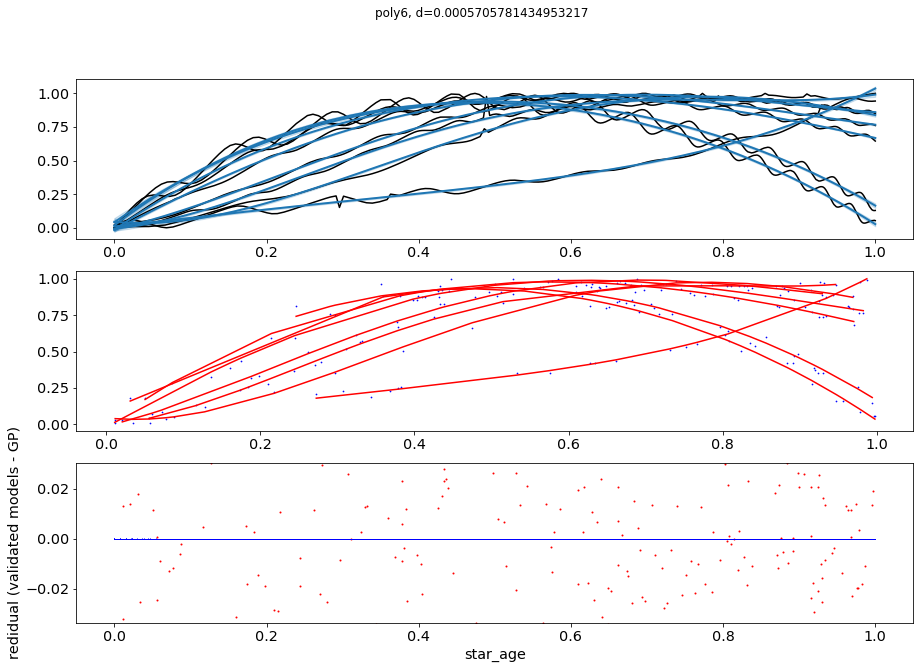

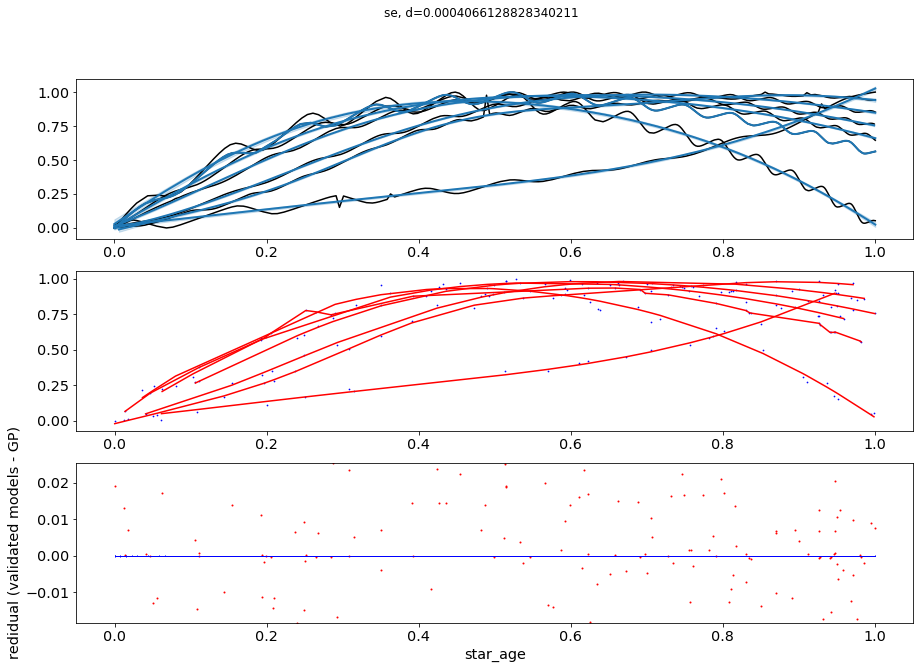

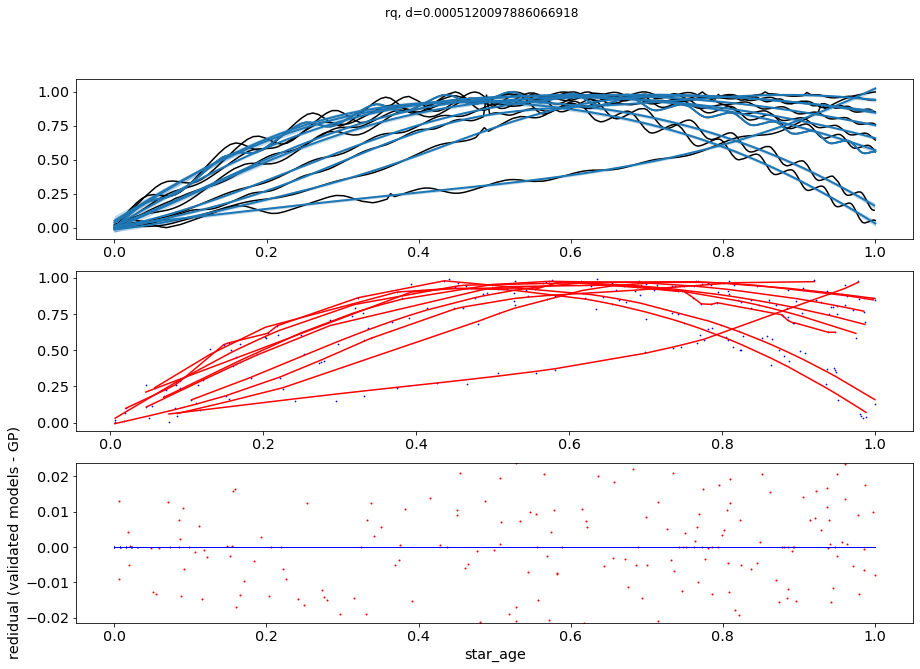

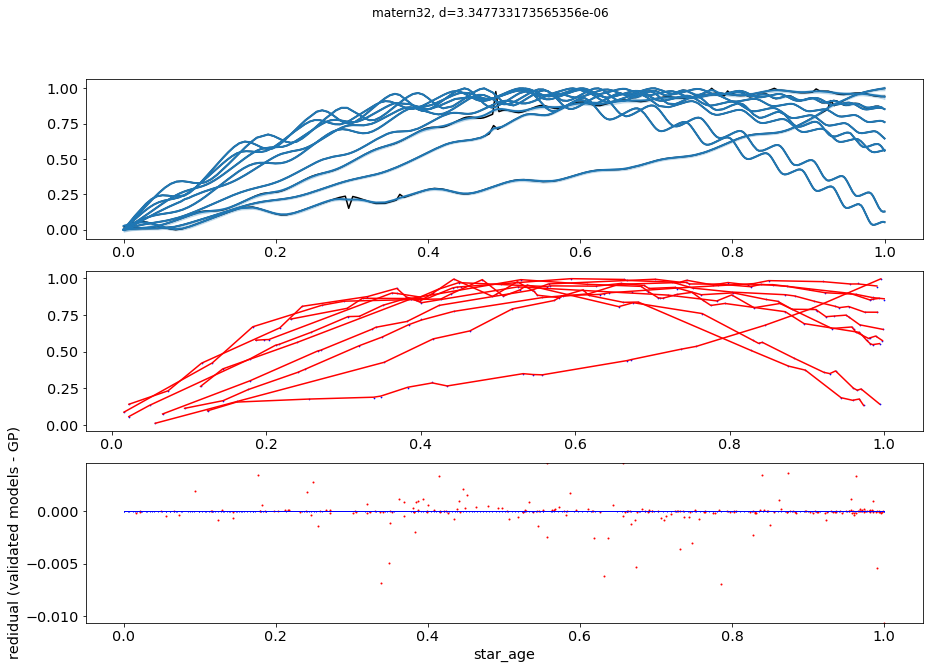

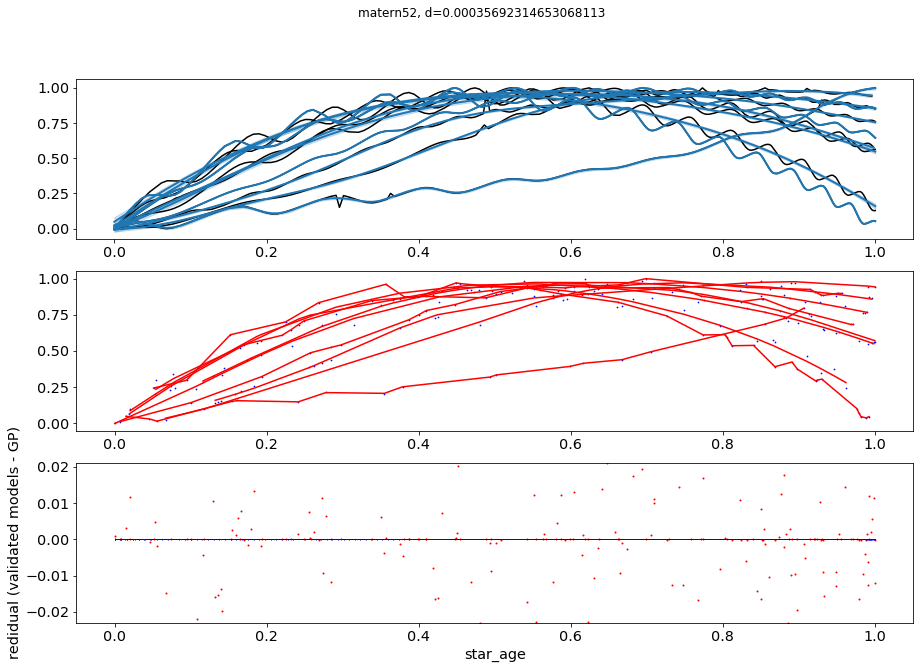

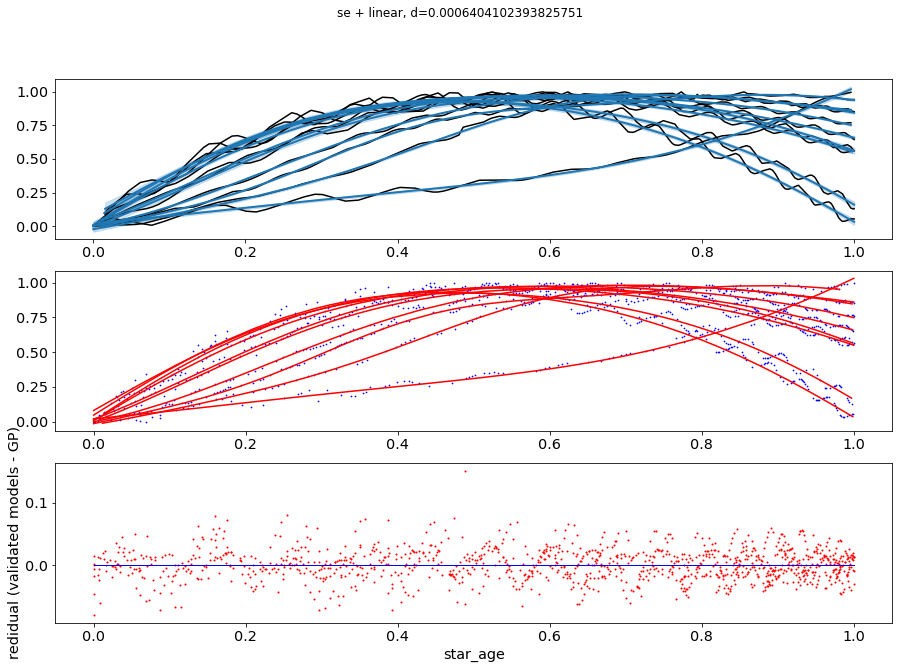

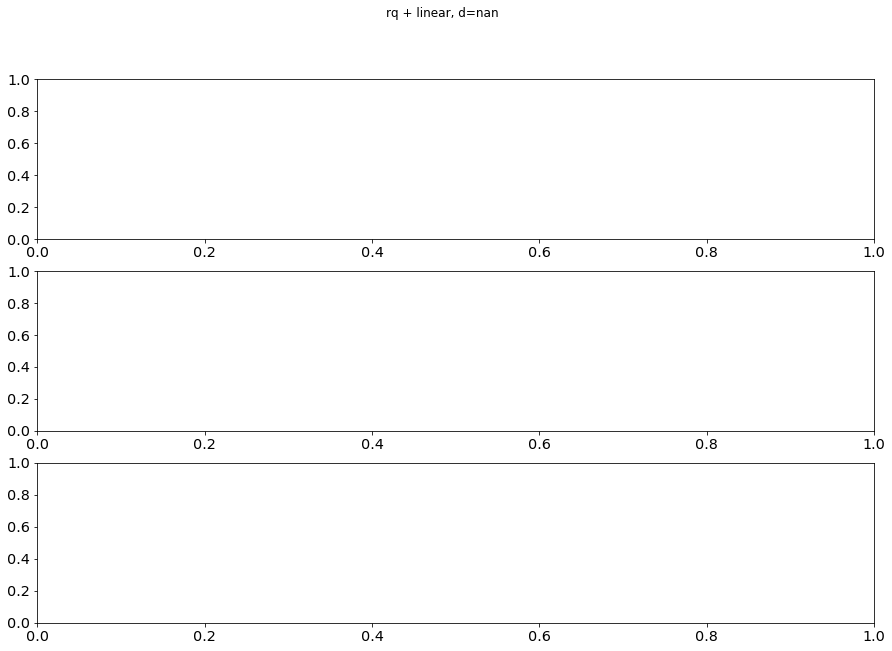

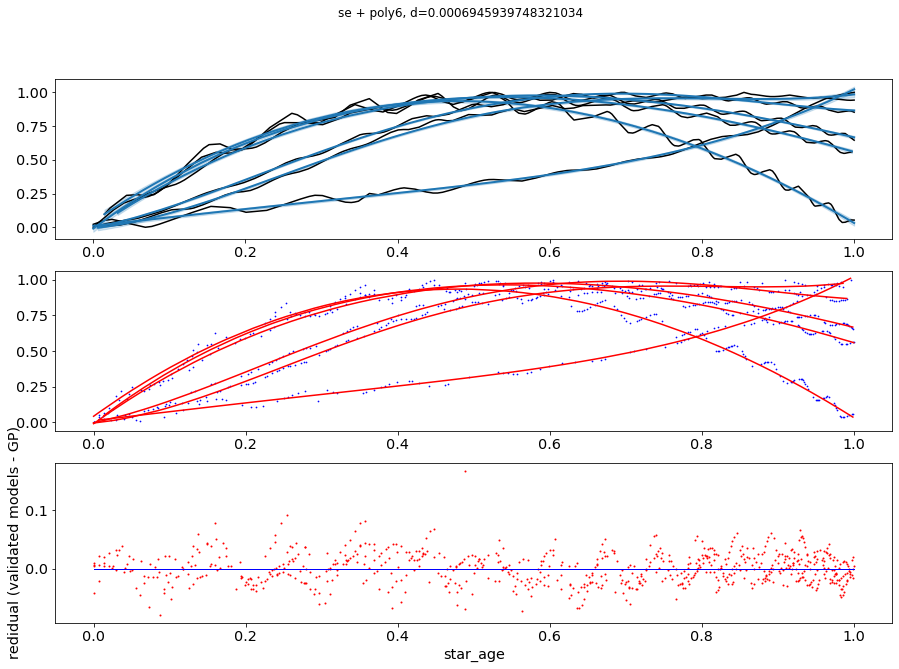

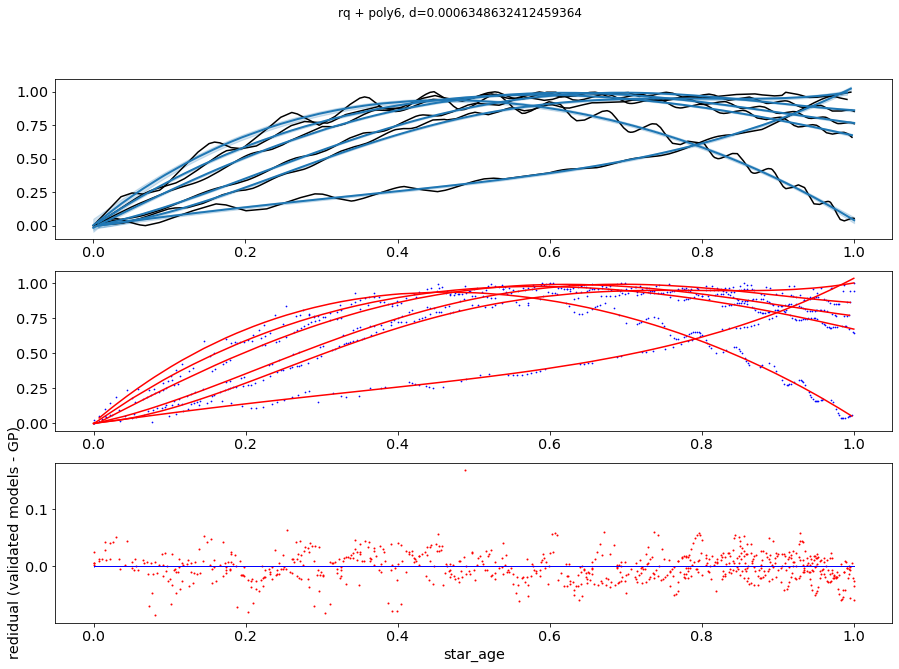

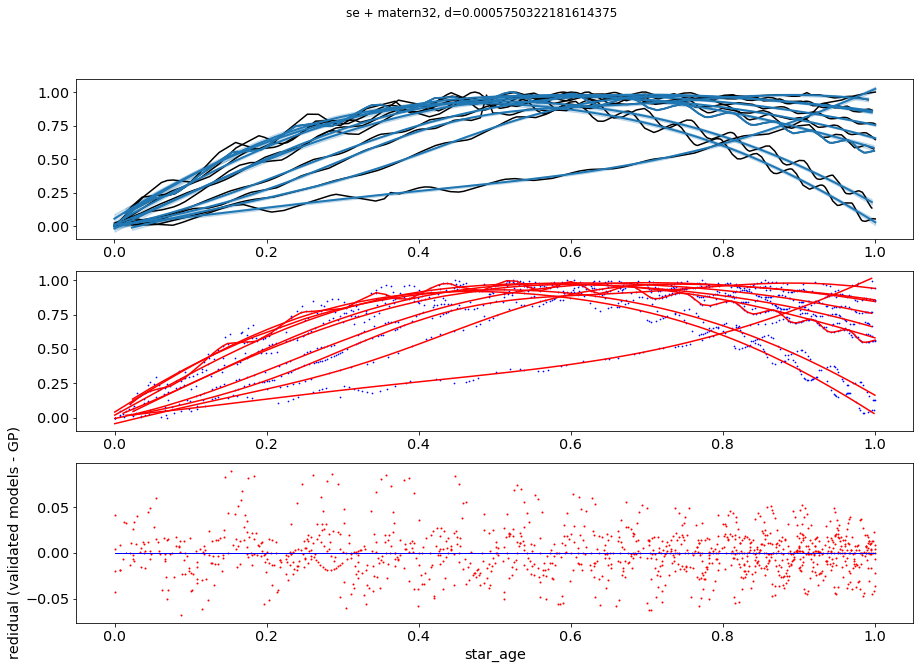

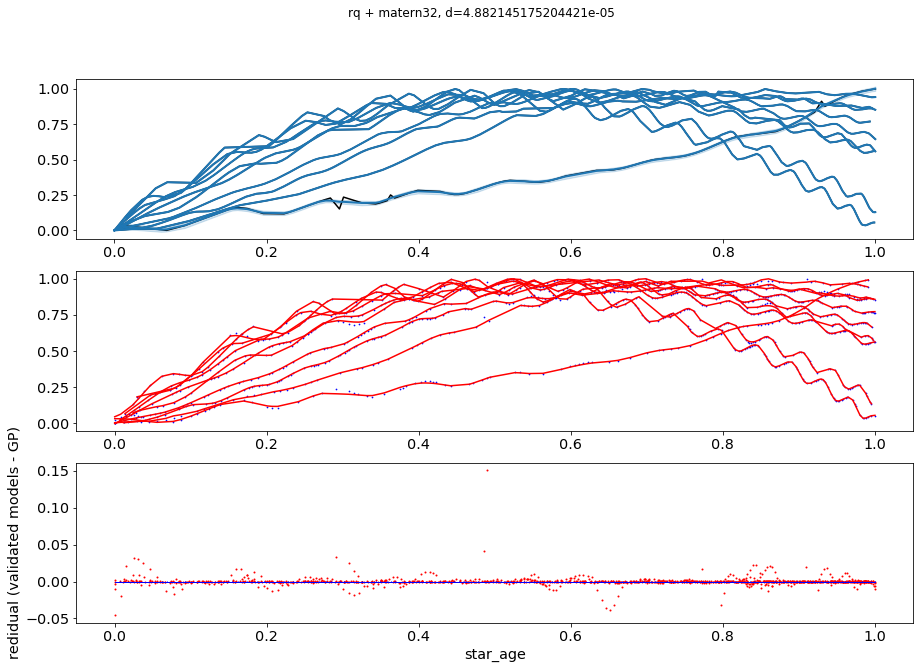

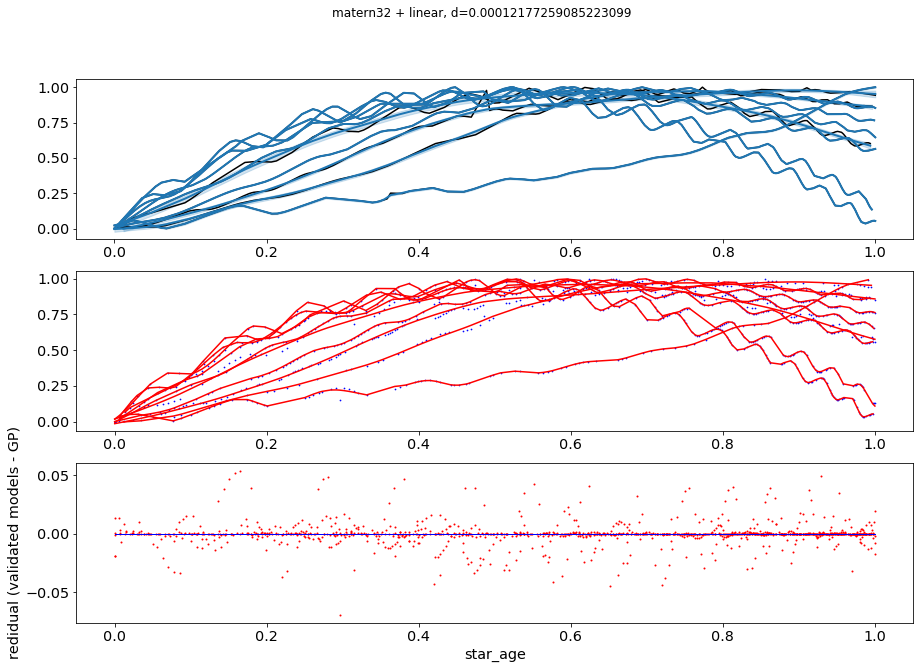

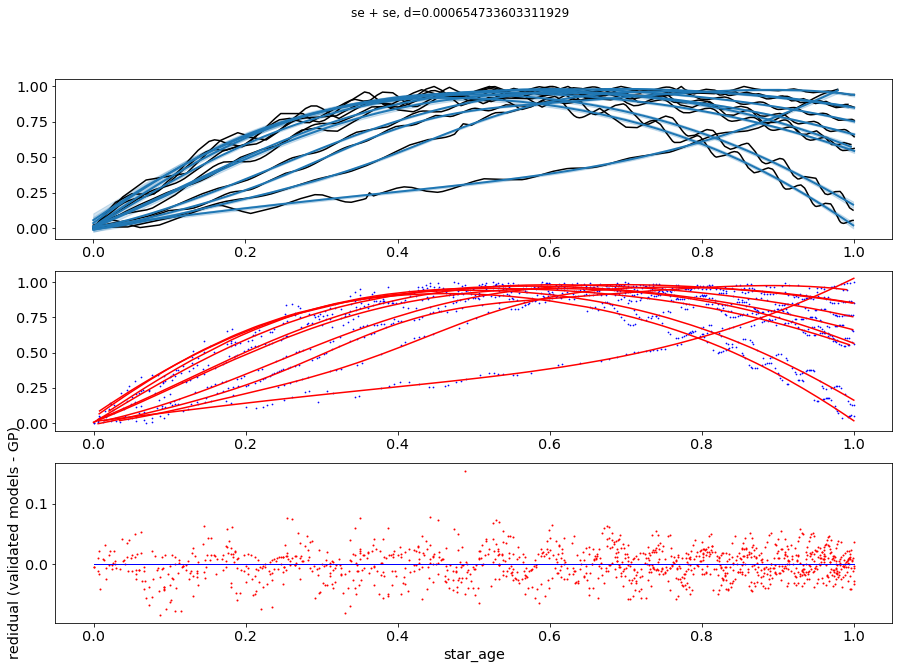

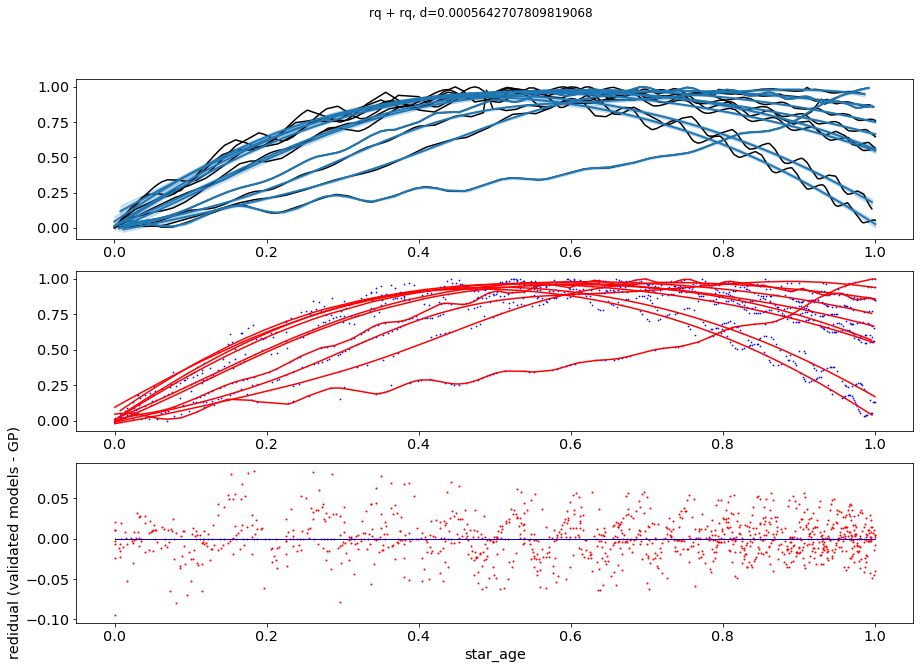

In [33]:
start_time = time.time()

teff_offset = gk.find_1d_kernel(condition = '*.csv',
                                subset_fraction = 0.2, 
                                x = 'star_age', y = 'nu_1_-10', 
                                x2 = False, xlog = False, ylog = False,
                                xnormalization = True,
                                ynormalization = True,
                                kernels = kernels, 
                                kernel_combinations = kernel_combinations,
                                iterations = 10, validation_frac = 0.1,
                                printinfo = False, figures = True)

print("--- %s seconds ---" % (time.time() - start_time))

In [34]:
teff_offset

poly6            se            rq      matern32      matern52  \
0 -9999.000000  1.566644e-07  1.703318e-08  5.224129e-08  7.679031e-04   
1     0.000284  1.895092e-04  1.512478e-04  5.207540e-09  6.572335e-09   
2     0.000261  3.458817e-04  4.897522e-04  6.984241e-06  7.868980e-06   
3     0.000320  3.975372e-04  2.705784e-04  1.228719e-07  1.209273e-08   
4     0.001689  1.693216e-03  1.618158e-03  3.361286e-08  1.122020e-08   
5     0.000288  1.053575e-04  1.186389e-04  1.302007e-05  1.091025e-04   
6     0.000329  1.146320e-04  1.322503e-04  2.806606e-07  1.873860e-04   
7 -9999.000000 -9.999000e+03  7.620537e-04  1.538081e-07  7.825479e-04   
8     0.001002 -9.999000e+03  1.384921e-03  6.453151e-08  1.507666e-03   
9     0.000391 -9.999000e+03  1.924805e-04  1.276009e-05  2.067273e-04   

   se + linear  rq + linear   se + poly6   rq + poly6  se + matern32  \
0     0.000592      -9999.0     0.000628 -9999.000000       0.000002   
1     0.000159      -9999.0     0.000210     0.000209       0.000149   
2     0.000573      -9999.0     0.000514     0.000535       0.000514   
3     0.000307      -9999.0     0.000365     0.000398       0.000396   
4     0.001737      -9999.0     0.001797     0.001685       0.001742   
5     0.000305      -9999.0     0.000654     0.000723       0.000109   
6     0.000189      -9999.0 -9999.000000     0.000259       0.000178   
7     0.000840      -9999.0 -9999.000000 -9999.000000       0.000811   
8     0.001534      -9999.0 -9999.000000 -9999.000000       0.001641   
9     0.000169      -9999.0 -9999.000000 -9999.000000       0.000208   

   rq + matern32  matern32 + linear   se + se   rq + rq  
0   4.164154e-07       4.360928e-07  0.000703  0.000618  
1   6.282299e-07       4.681489e-07  0.000157  0.000006  
2   8.513133e-05       9.676609e-05  0.000530  0.000110  
3   3.247523e-07       6.901795e-06  0.000309  0.000349  
4   6.670331e-06       4.021683e-06  0.001697  0.001597  
5   2.056154e-04       1.369964e-04  0.000299  0.000122  
6   1.959143e-06       5.090333e-06  0.000182  0.000187  
7   8.027441e-05       8.050833e-04  0.000844  0.000822  
8   2.818884e-05       1.331779e-05  0.001610  0.001637  
9   7.900564e-05       1.486444e-04  0.000217  0.000195

In [35]:
np.mean(teff_offset)

poly6               -1999.799544
se                  -2999.699715
rq                      0.000512
matern32                0.000003
matern52                0.000357
se + linear             0.000640
rq + linear         -9999.000000
se + poly6          -3999.599583
rq + poly6          -3999.599619
se + matern32           0.000575
rq + matern32           0.000049
matern32 + linear       0.000122
se + se                 0.000655
rq + rq                 0.000564
dtype: float64

In [36]:
np.std(teff_offset)

poly6                3999.600228
se                   4582.117624
rq                      0.000539
matern32                0.000005
matern52                0.000479
se + linear             0.000541
rq + linear             0.000000
se + poly6           4898.489928
rq + poly6           4898.489899
se + matern32           0.000601
rq + matern32           0.000063
matern32 + linear       0.000235
se + se                 0.000544
rq + rq                 0.000577
dtype: float64

In [37]:
teff_offset.to_csv(savedr + 'logg_kernel_test.csv')


We got several kernels which look promising. They are

exponential, matern12, constant + exponetial, constant + matern12, matern12 + matern12, exponential + exponential, matern12 + exponential

We may want a second match with only those kernels but more files and see who wins. 

Data path is set as/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/
Save path is set as/Users/litz/Documents/GitHub/GPflow/nu_1_-10/test2/
Initial guesses of kernels are:
[['matern32'], ['constant + matern32', 'linear + matern12']]
15/50tracks are used.
working on kernel: matern32(1/1)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:351: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:363: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:353: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:354: RuntimeWarning: invalid value encountered in sqrt


working on kernel combinations: constant + matern32(1/2)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:400: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:411: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:400: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:411: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


working on kernel combinations: linear + matern12(2/2)
--- 95.9535460472107 seconds ---


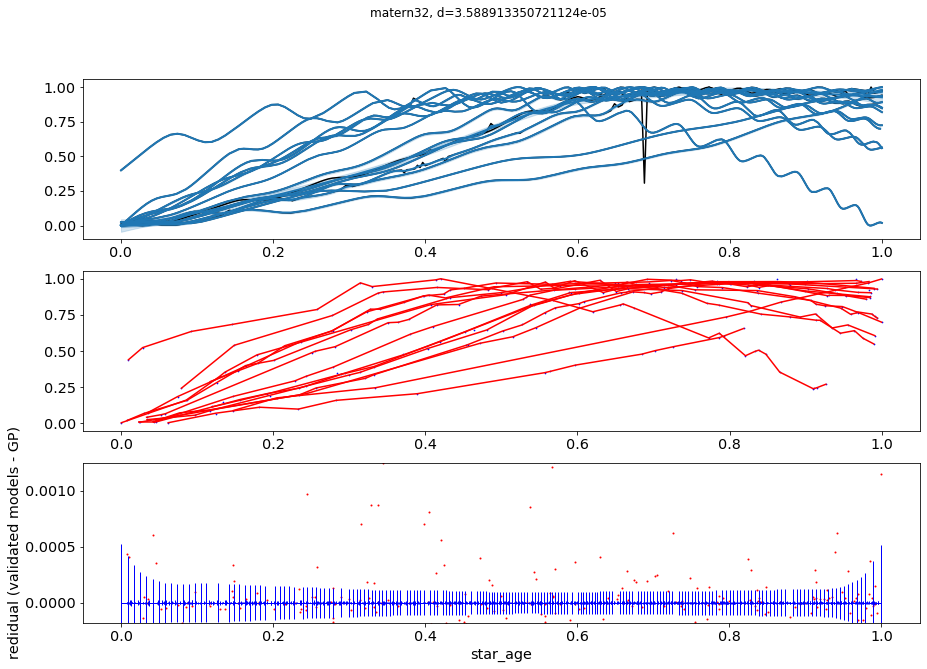

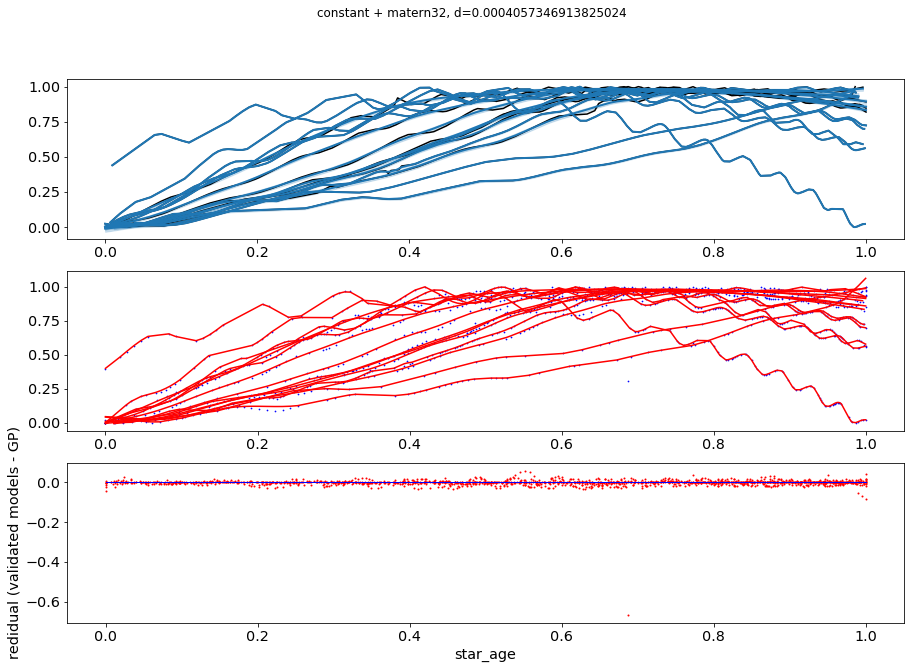

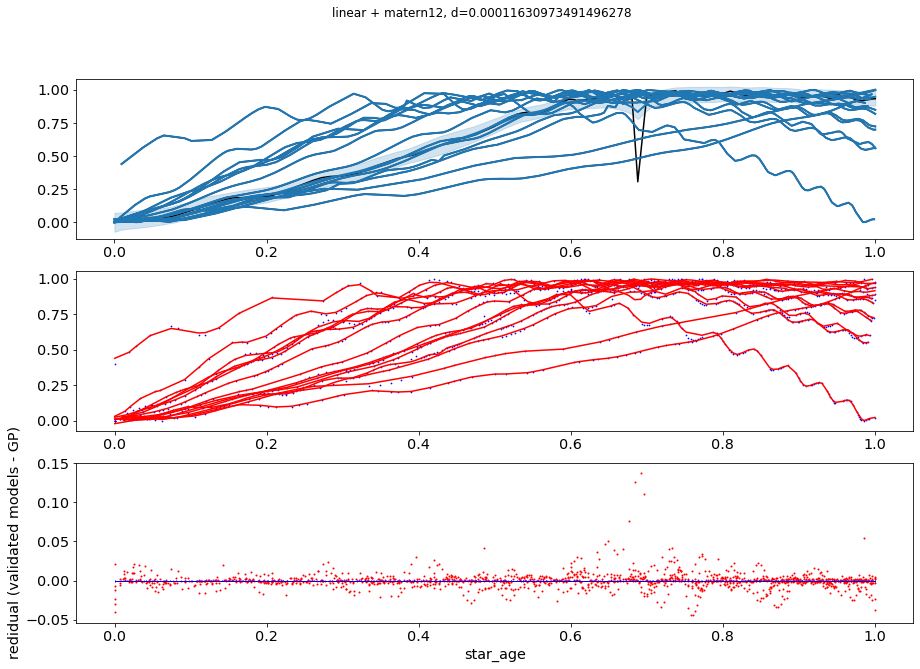

In [38]:
datadr = '/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/'
savedr = '/Users/litz/Documents/GitHub/GPflow/nu_1_-10/test2/'

gk = seismic_1d_kernel()
gk.set_path(datapath = datadr, savepath = savedr)


kernels = ['matern32']
kernel_combinations = [
                       'constant + matern32',
                       'linear + matern12'
                      ]



start_time = time.time()

teff_offset_2 = gk.find_1d_kernel(condition = '*.csv',
                                subset_fraction = 0.3, 
                                x = 'star_age', y = 'nu_1_-10', 
                                x2 = False, xlog = False, ylog = False,
                                xnormalization = True,
                                ynormalization = True,
                                kernels = kernels, 
                                kernel_combinations = kernel_combinations,
                                iterations = 10, validation_frac = 0.1,
                                printinfo = False, figures = True)

print("--- %s seconds ---" % (time.time() - start_time))

In [39]:
teff_offset_2.to_csv(savedr + 'teff_kernel_test_2.csv')

In [40]:
teff_offset_2

matern32  constant + matern32  linear + matern12
0   4.406010e-04             0.004513           0.000765
1   8.788231e-07             0.000130           0.000114
2   1.858293e-06             0.000181           0.000095
3   6.901333e-09             0.000147           0.000031
4   5.065713e-06             0.000224           0.000047
5   1.023038e-07             0.000001           0.000029
6   6.059834e-06             0.000068           0.000045
7   5.981948e-07             0.000064           0.000044
8   3.185040e-07             0.000128           0.000053
9   7.708875e-08             0.000030           0.000135
10  2.484033e-06             0.000265           0.000050
11  3.685275e-05             0.000178           0.000181
12  5.284717e-08             0.000007           0.000015
13  4.328525e-05             0.000145           0.000093
14  9.543894e-08             0.000004           0.000046

In [41]:
np.mean(teff_offset_2[teff_offset_2 > 0.0])

matern32               0.000036
constant + matern32    0.000406
linear + matern12      0.000116
dtype: float64

In [42]:
np.std(teff_offset_2[teff_offset_2 > 0.0])


matern32               0.000109
constant + matern32    0.001101
linear + matern12      0.000179
dtype: float64

# Step 4 Apply the best GP kernel to the whole grid

We found that 'matern32' is the best and the most stable kernel. We hence apply it to the whole grid. 

gk.apply_1d_kernel uses an input kernel to model a stellar parameter as a function of the other parameter for each evolutionary track. The output is one GP model per track. 

gk.apply_1d_kernel returns a pandas.dataframe which content the deviation between the GP model and the data for each evolutionary track. The dataframe looks like: 

-------------
index,     evolutionary_track,       x,          y,        xlog,    ylog,     xrange,       yrange,         xnormalization,     ynormalization,     mean_deviation,     max_deviation,        saveGPmodel         

  1,      m1.0_feh2.0_MLT...,   star_age,   effective_T,    True,    True,  [-4.5, 10.],   [3.6,3.8] ,       Ture ,     Ture,      1.0d-8,            1.0d-4,     GPmodel-effective_T...
  ......

validate_mean and validate_sigma is the mean and the standard devitation of the probability distribution of residuals between model and data. The two parameters will be used to estimate the uncertainty of a predication value. 

xrange and yrange gives a parameter space in which the derived GP model can be trust. Obviously, this space can not exceed the min/max of x and y values. To avoid edge effects, we removed edge spaces where model predictions is 3sigma away from validations.      
  

In [53]:
datadr = '/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/'
savedr = '/Users/litz/Documents/GitHub/GPflow/nu_1_-10/'
gk = seismic_1d_kernel()
gk.set_path(datapath = datadr, savepath = savedr)


kernels = ['matern32']

Data path is set as/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/
Save path is set as/Users/litz/Documents/GitHub/GPflow/nu_1_-10/


50 files are found in /Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/ with the condition *.csv


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:531: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:544: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:533: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:534: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:529: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

--- 119.70991730690002 seconds ---


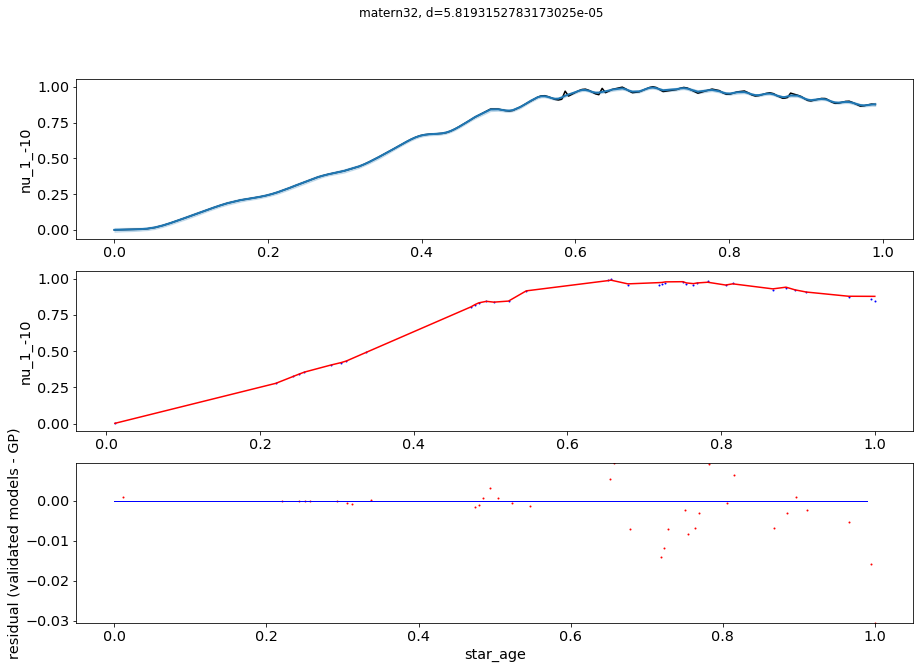

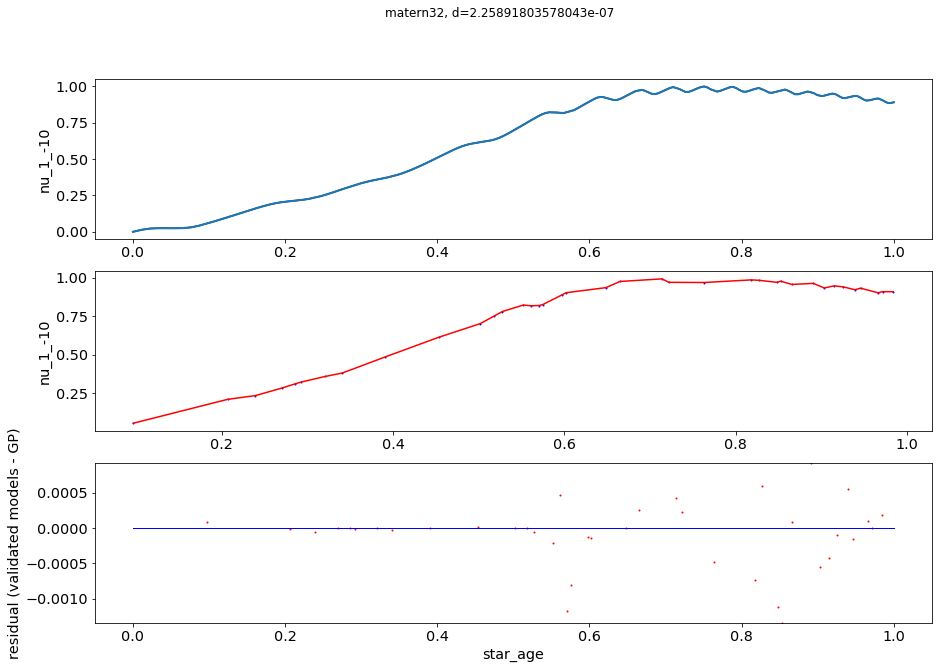

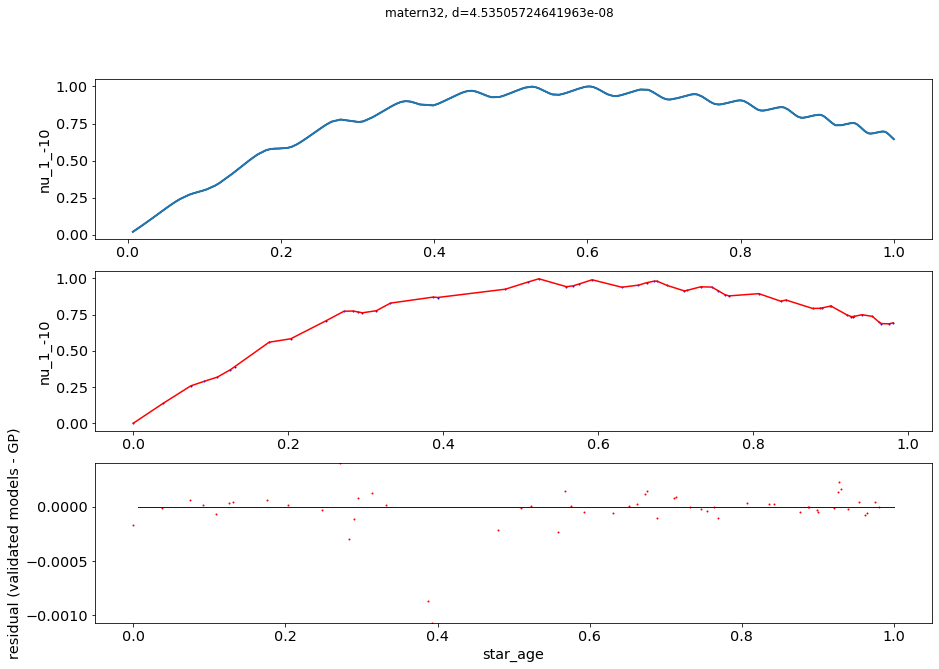

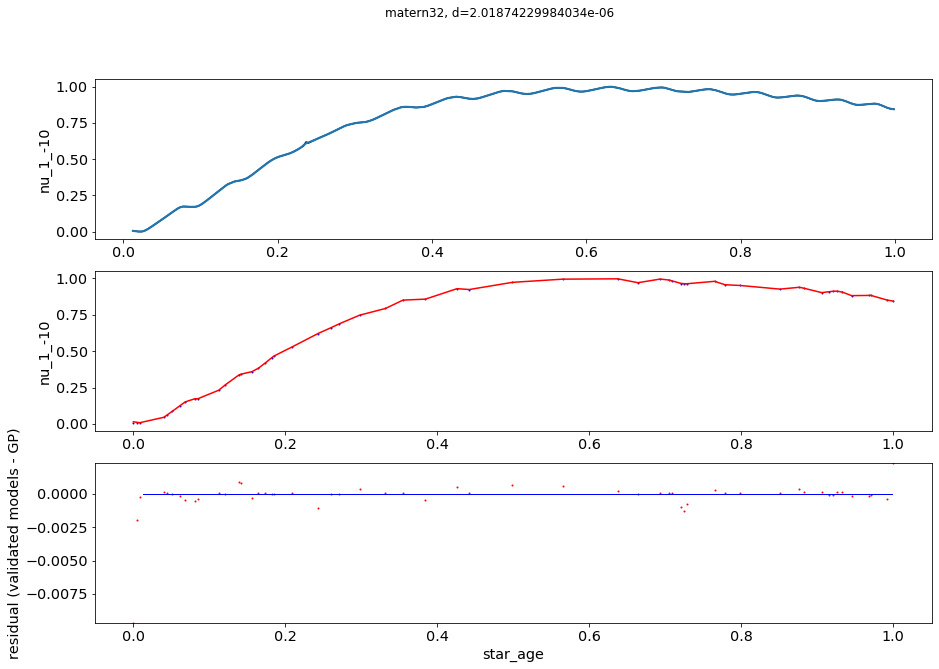

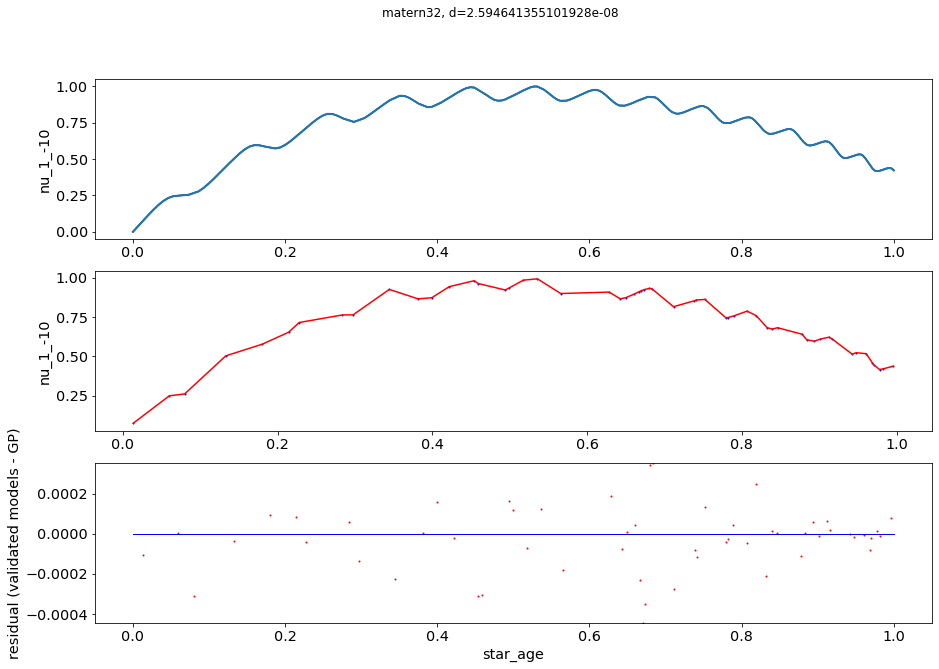

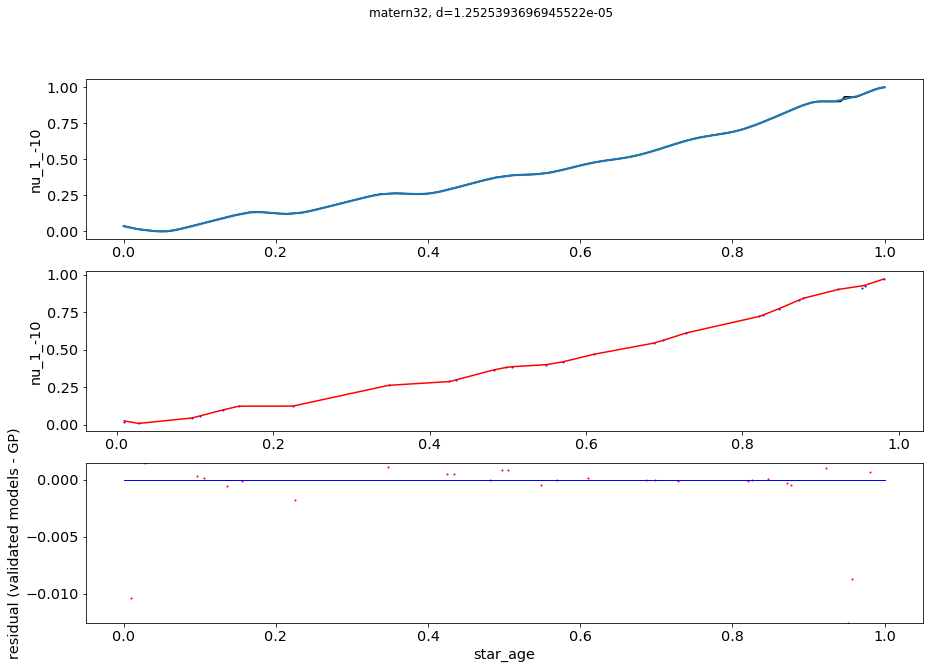

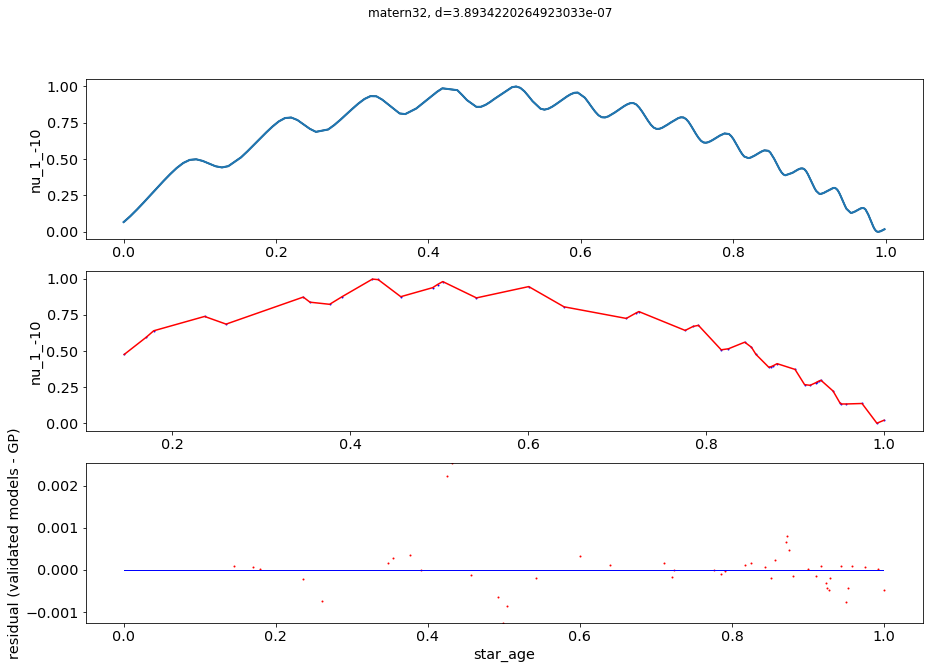

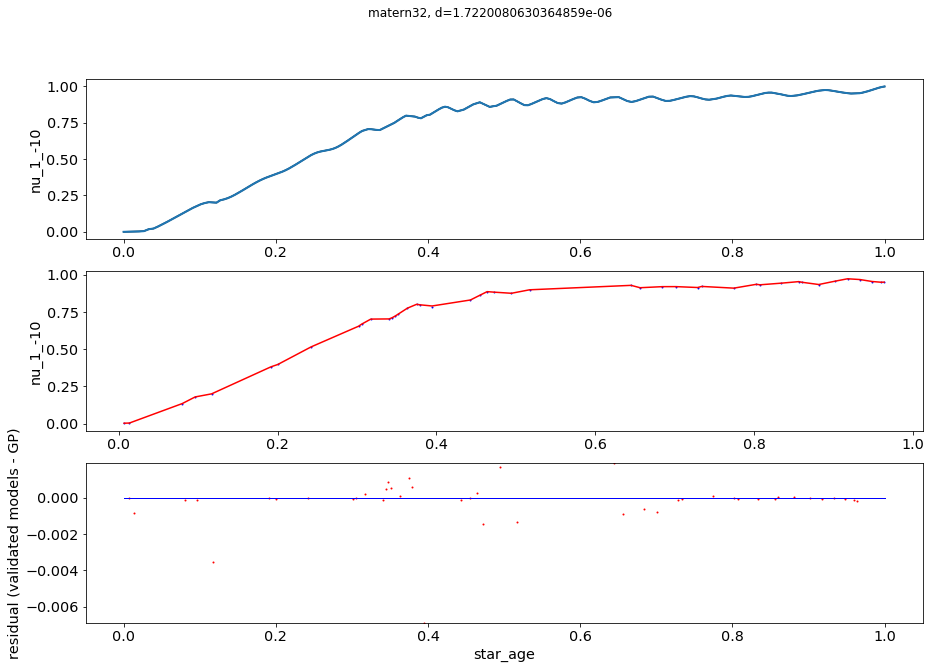

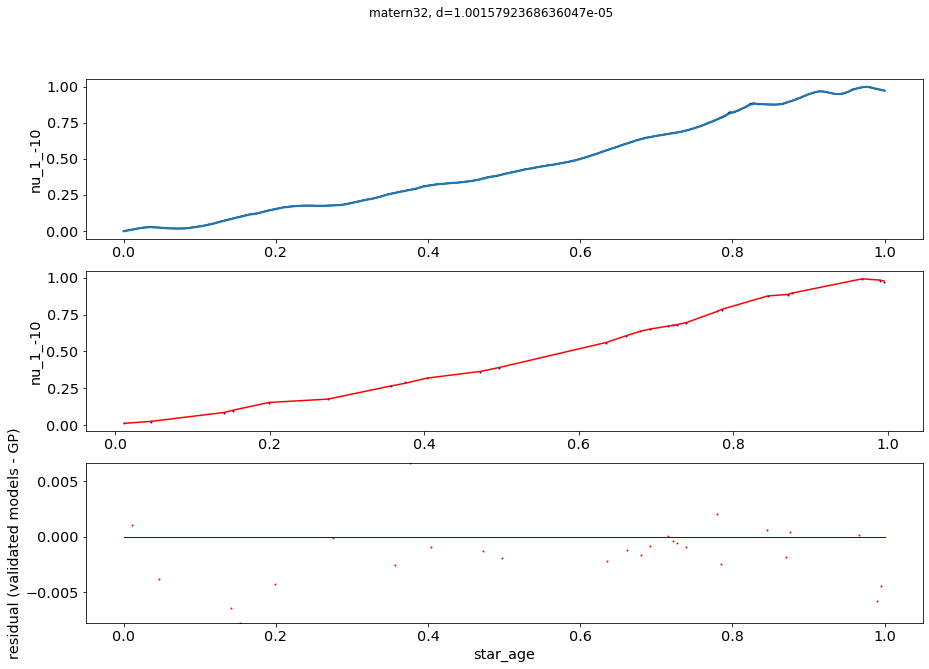

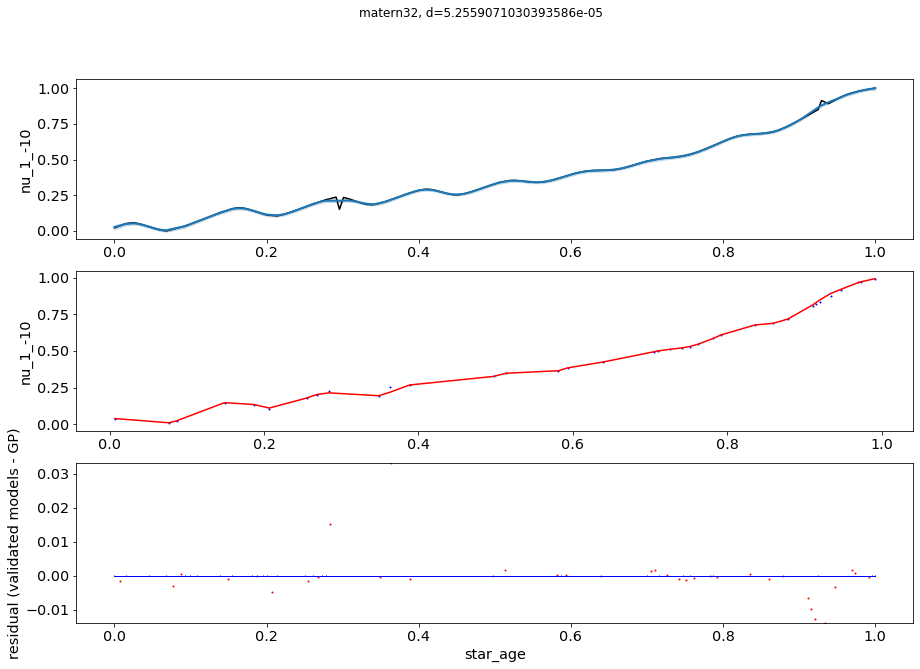

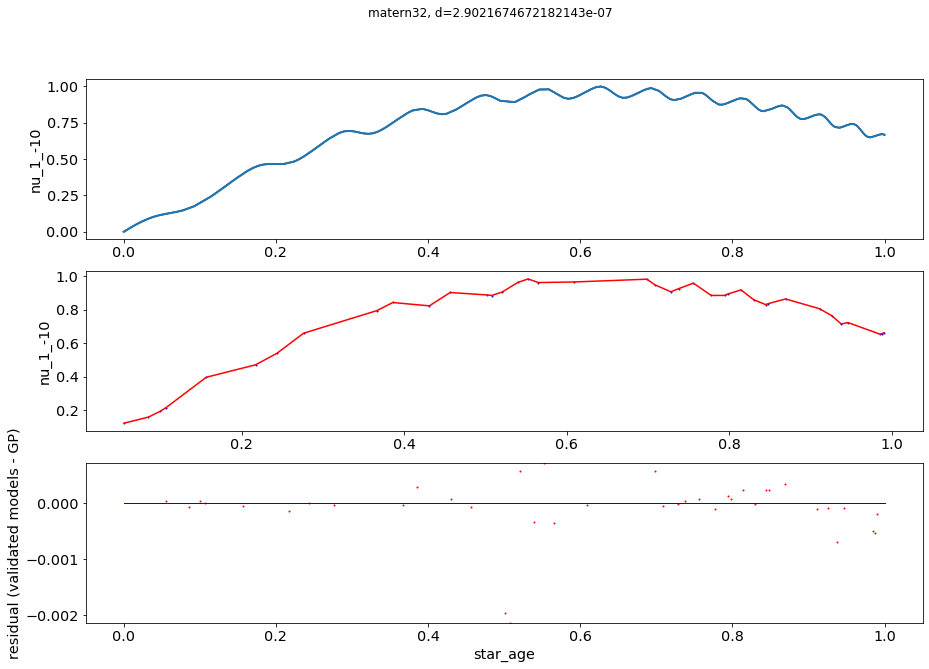

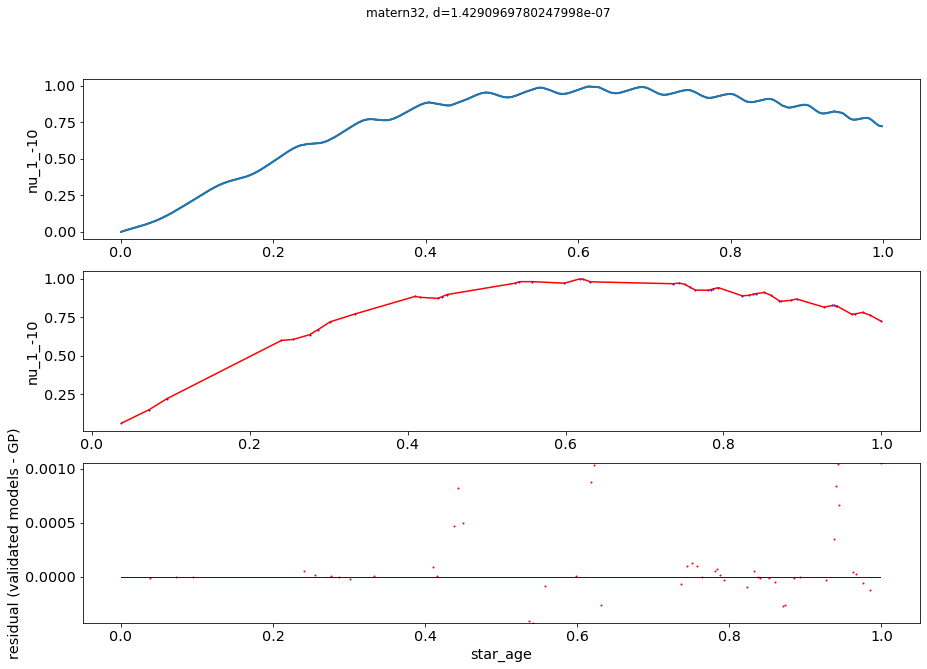

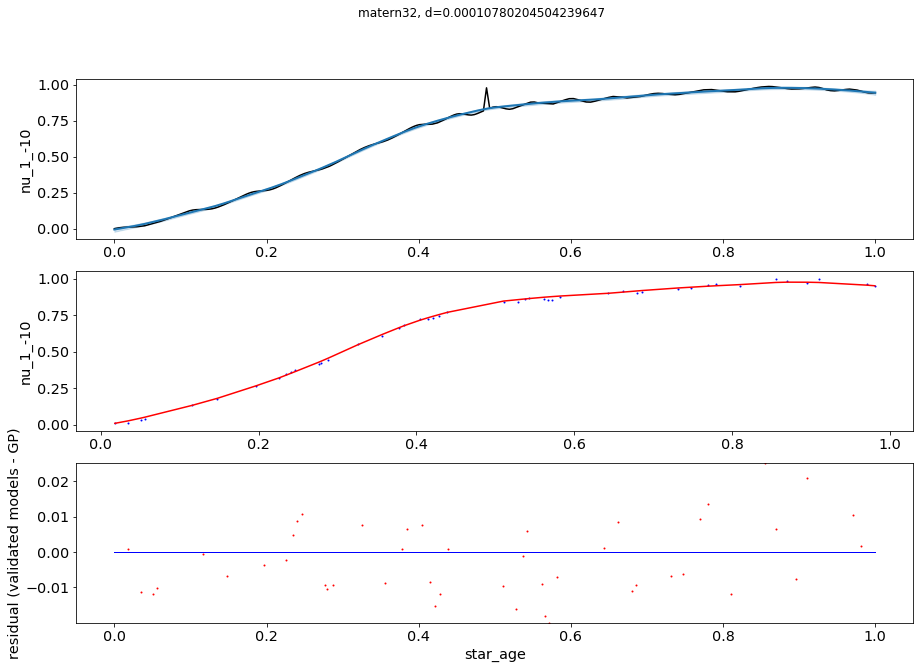

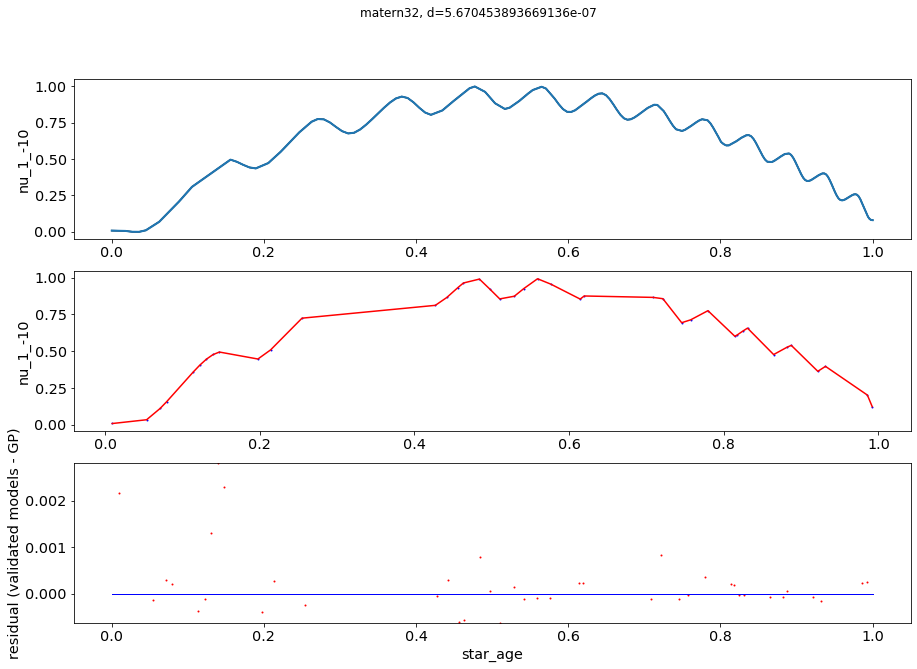

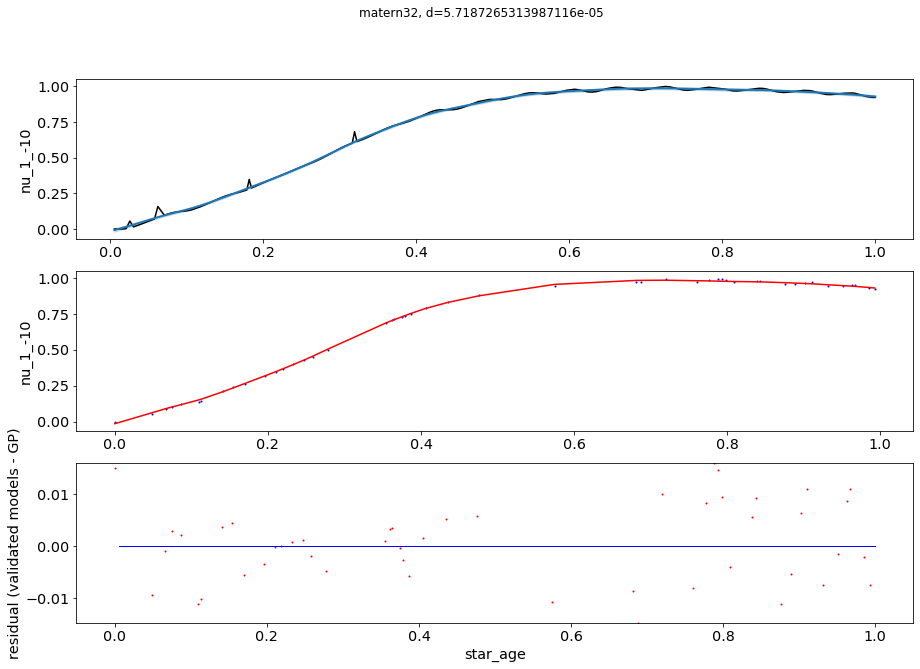

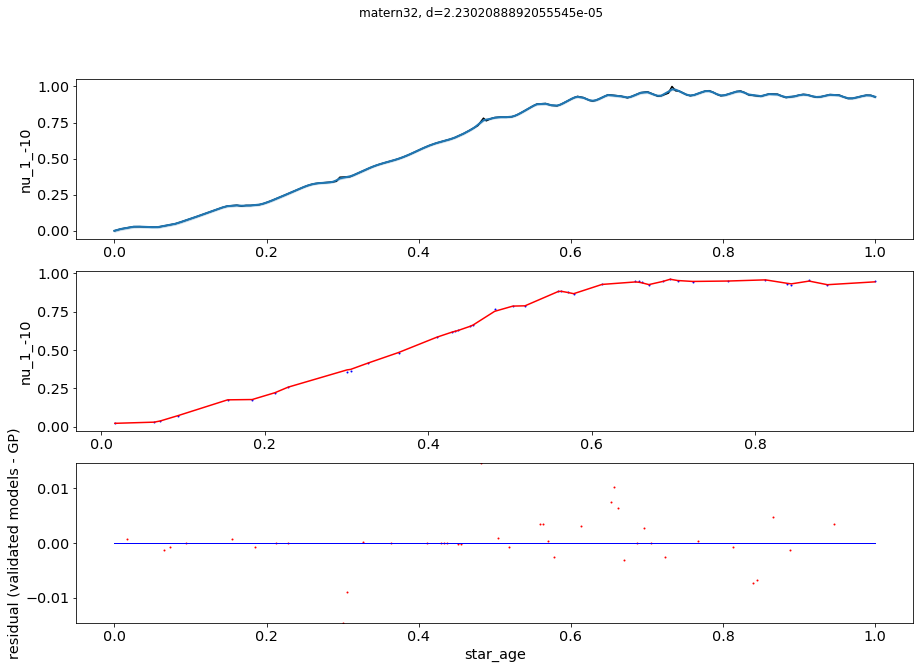

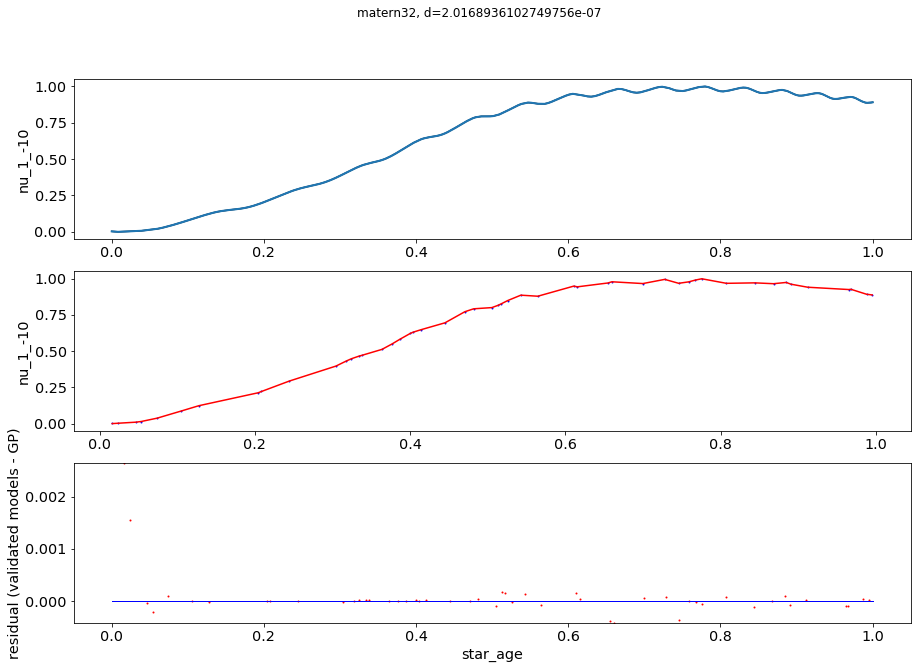

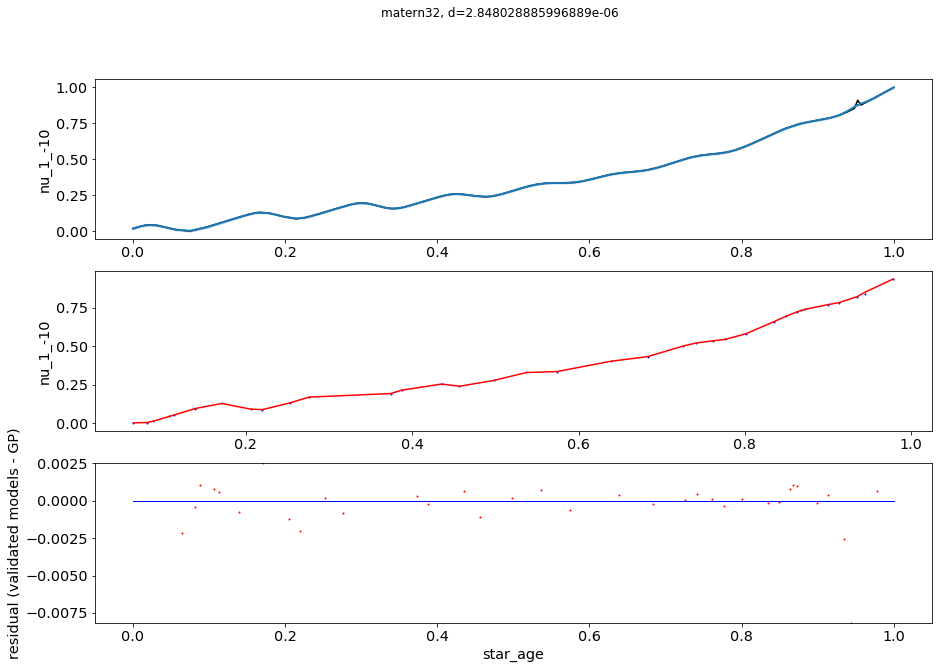

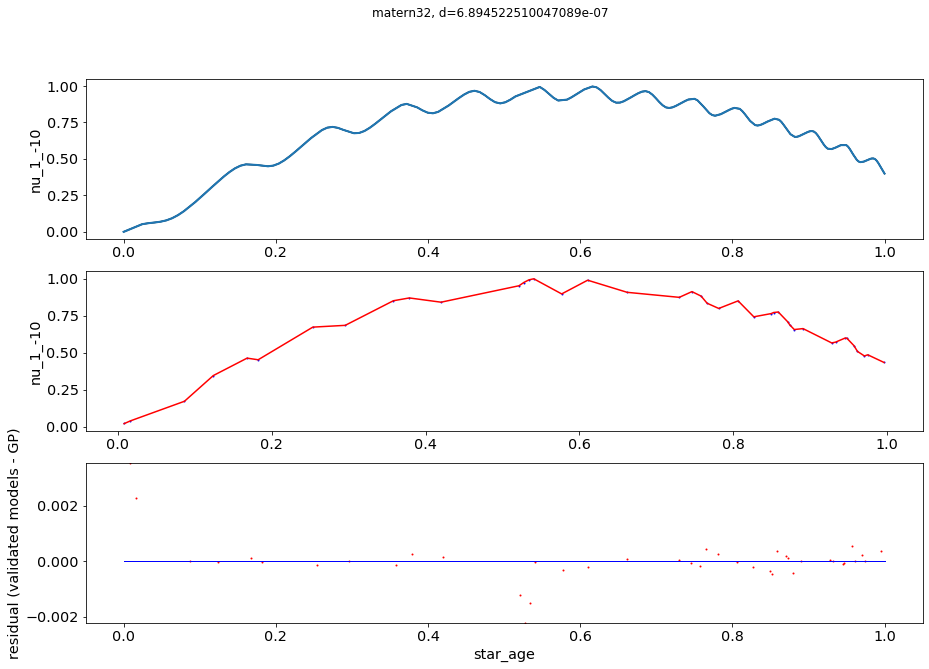

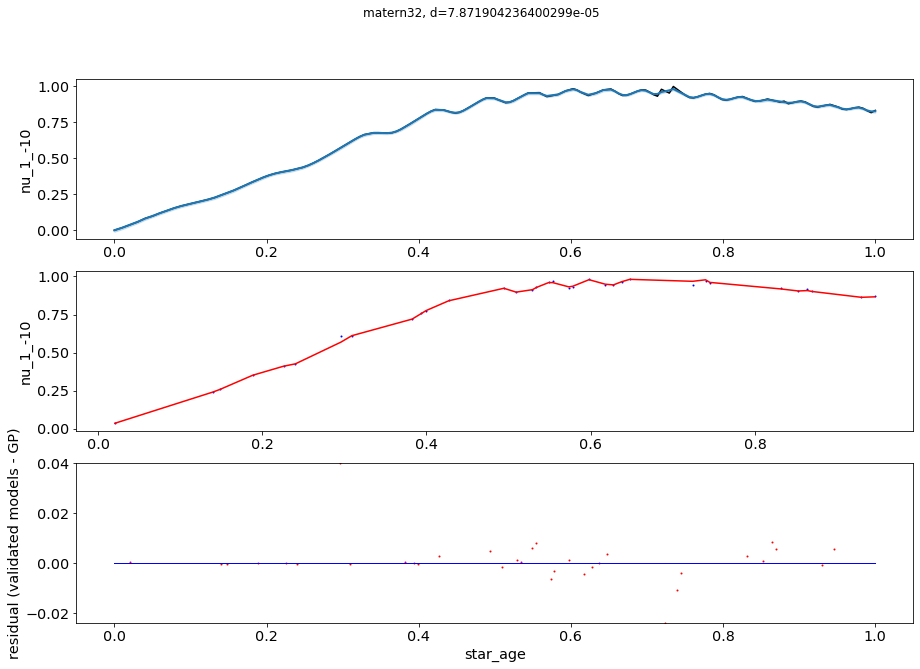

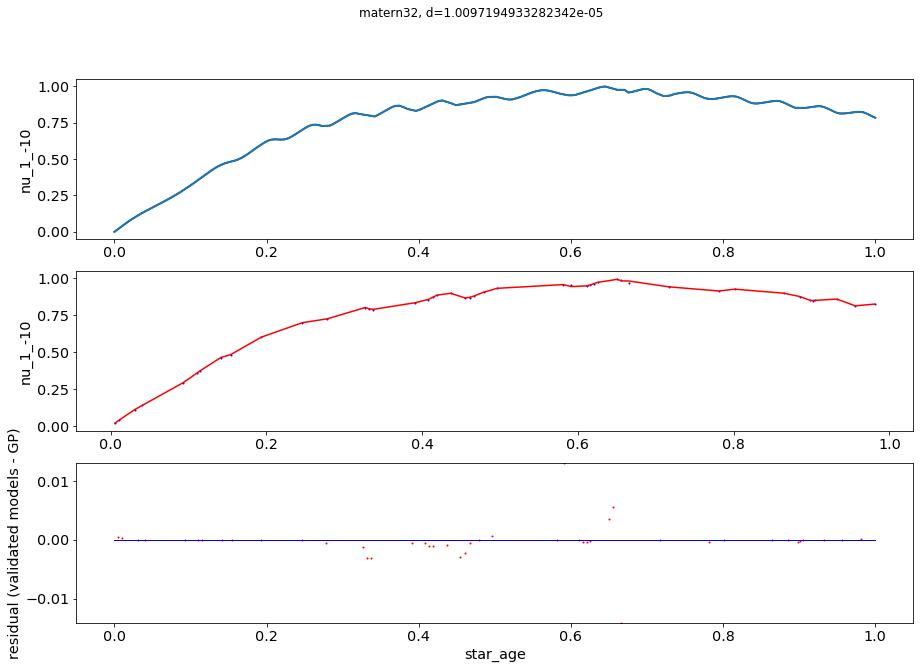

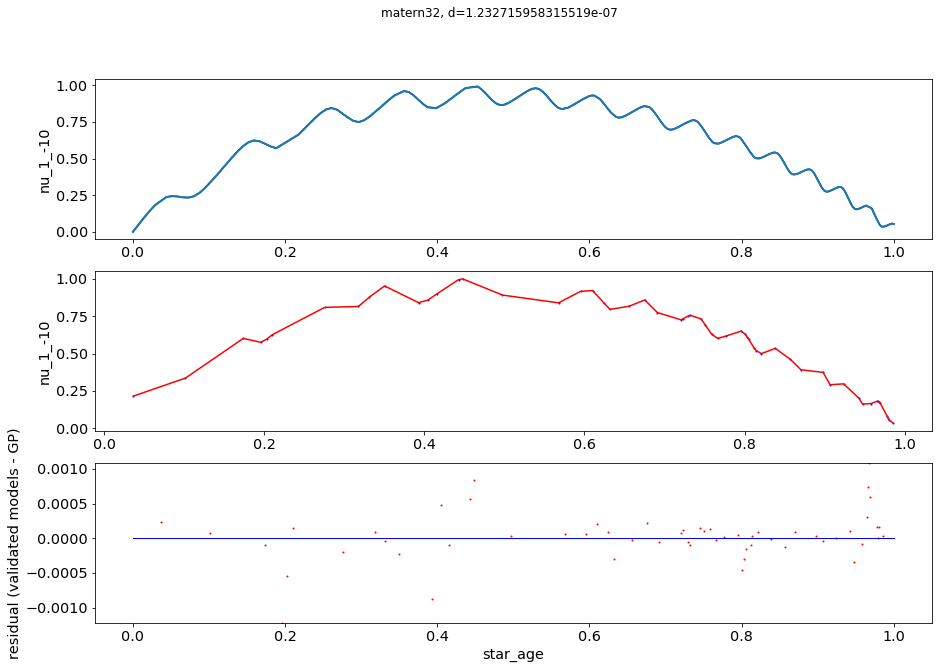

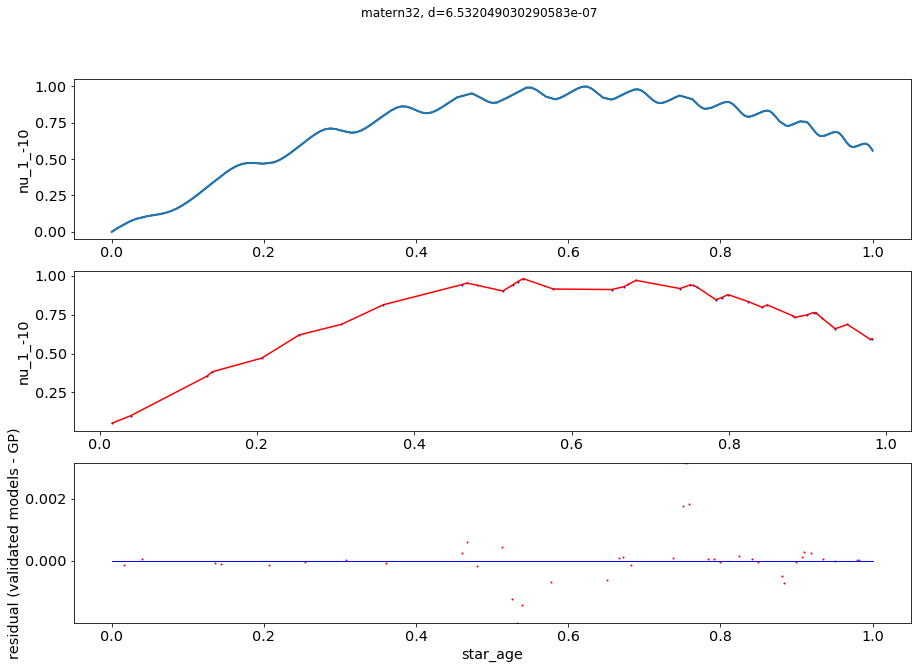

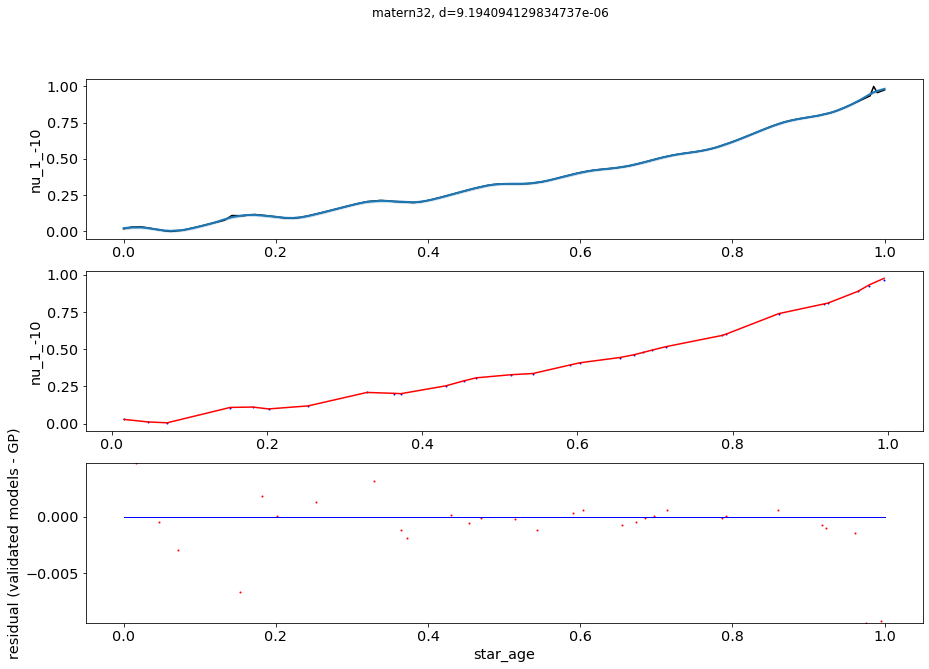

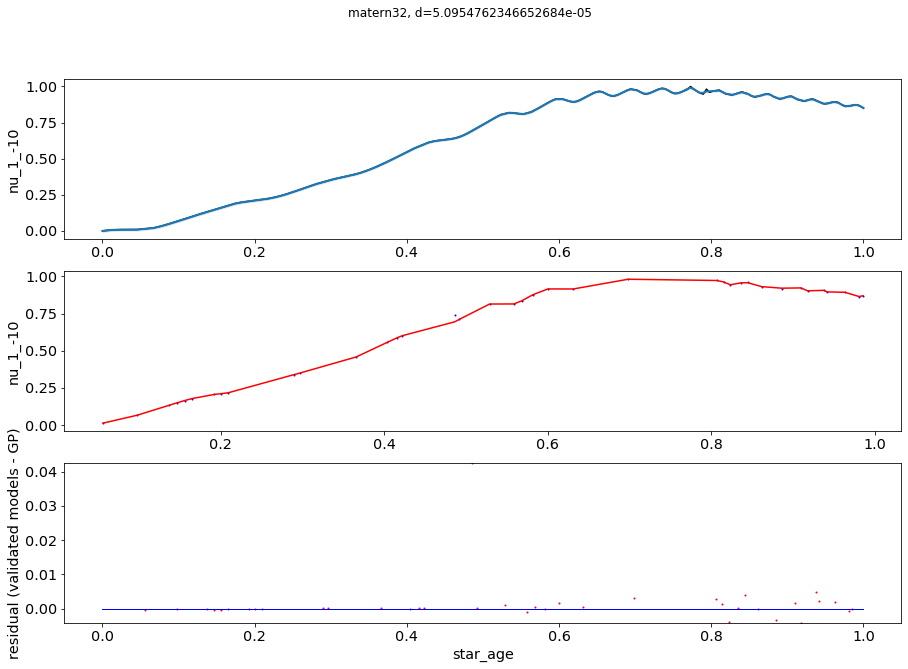

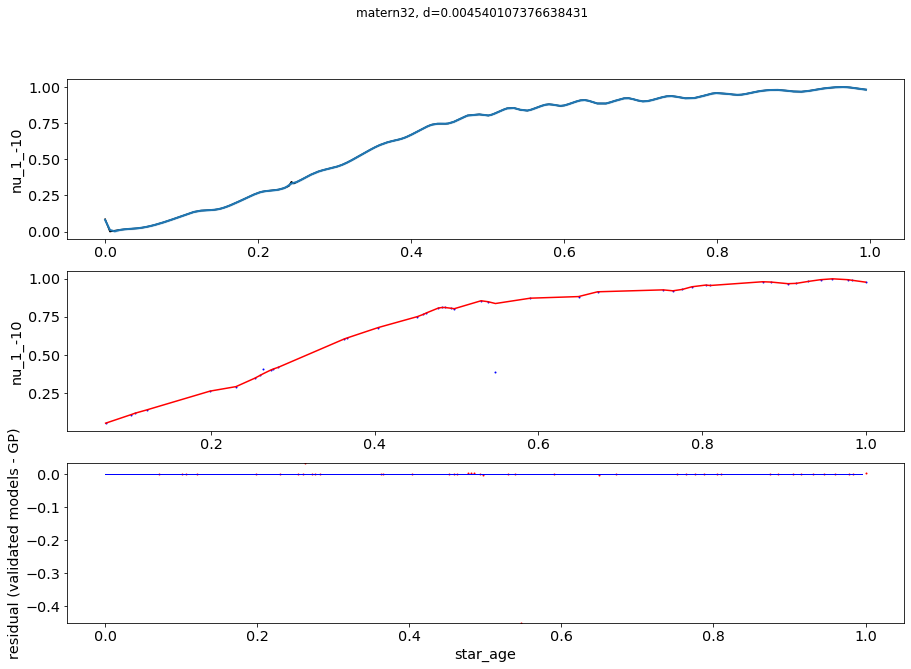

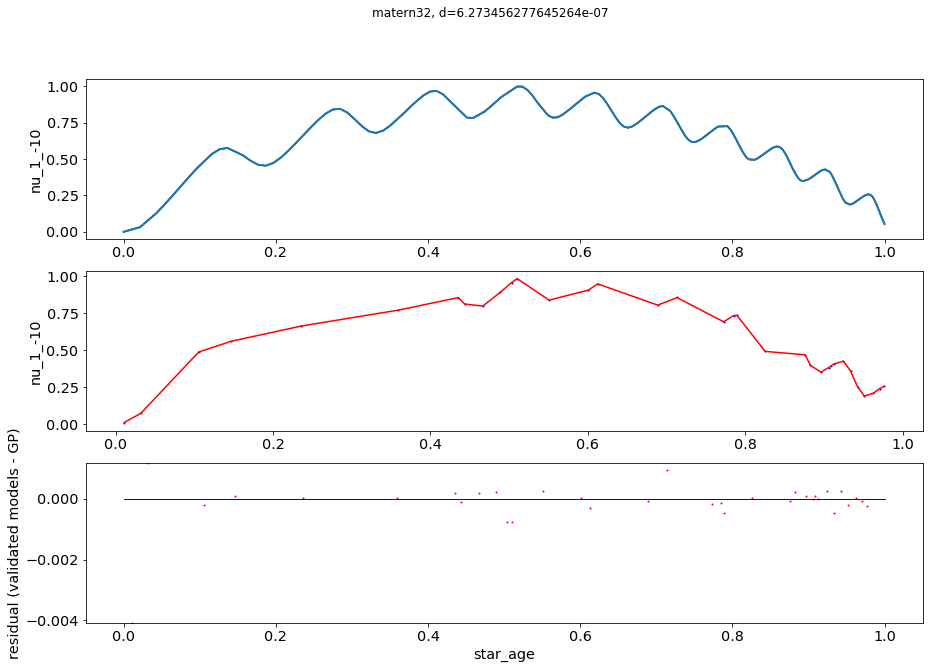

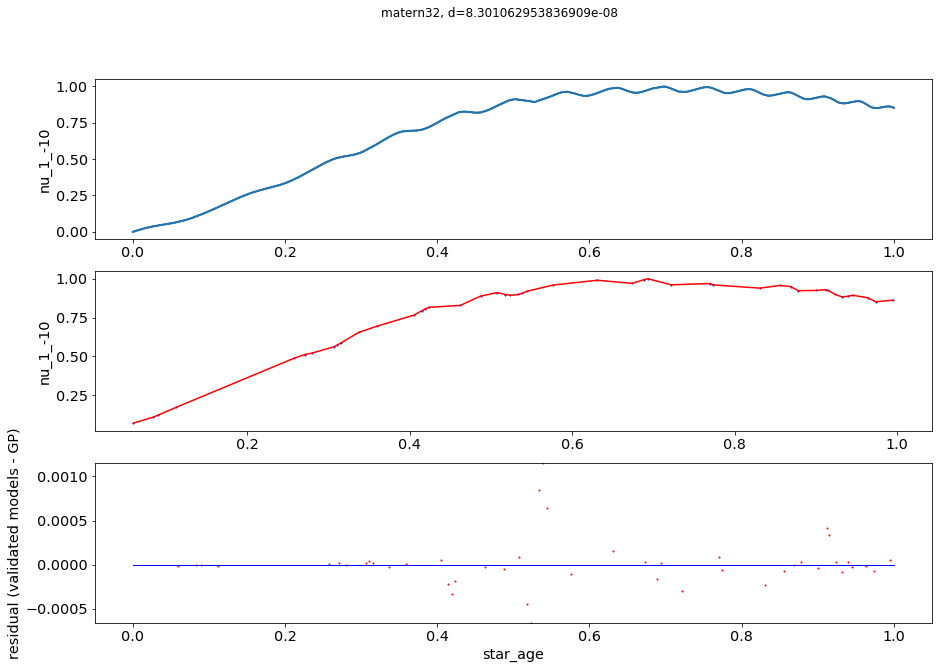

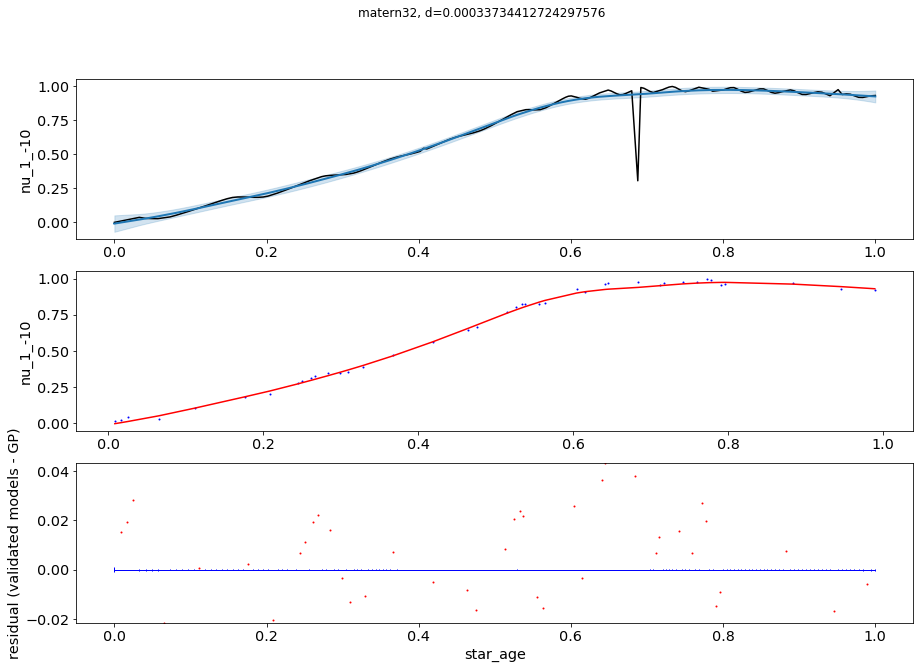

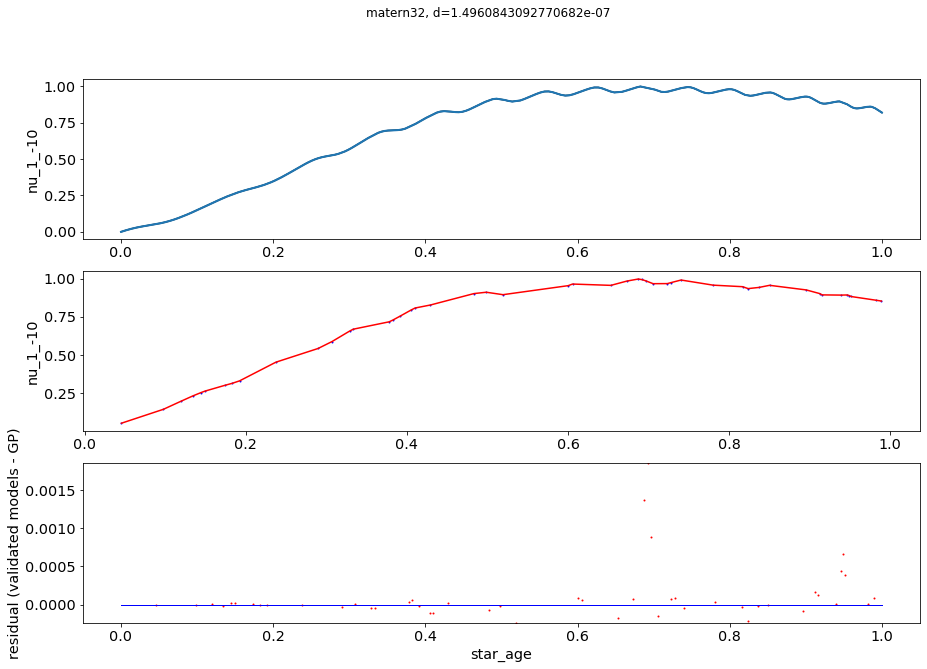

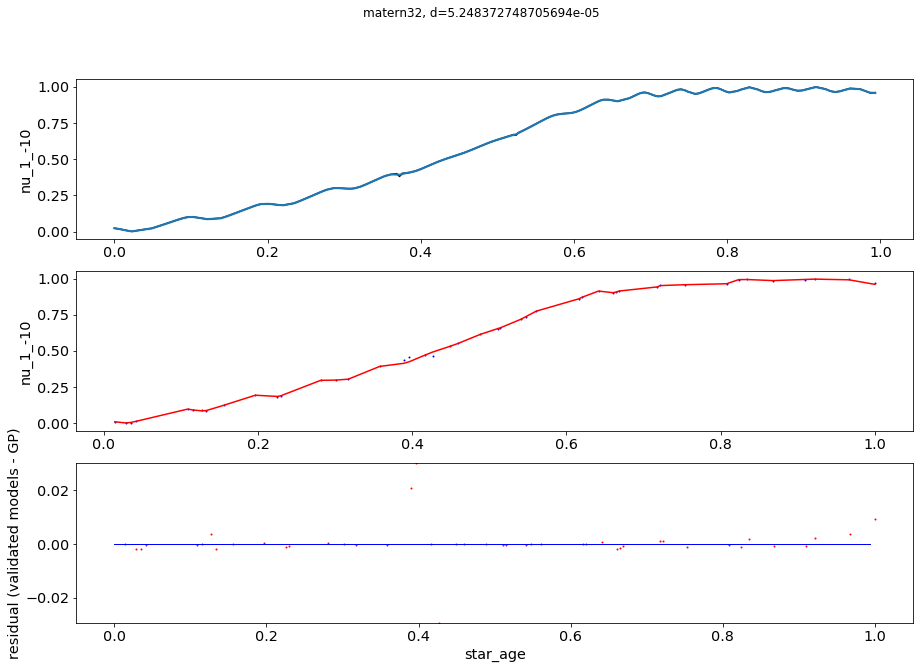

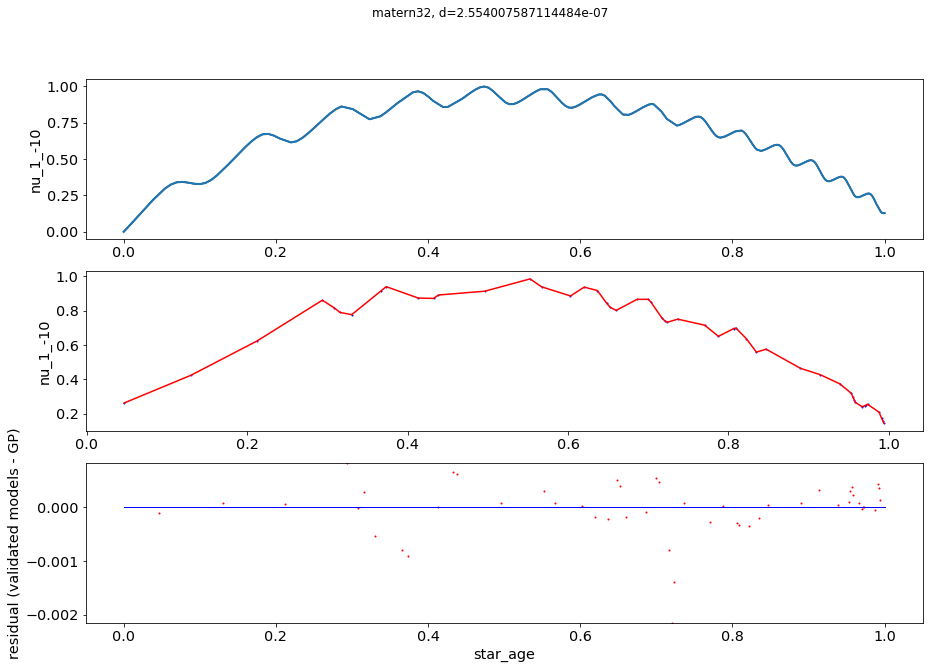

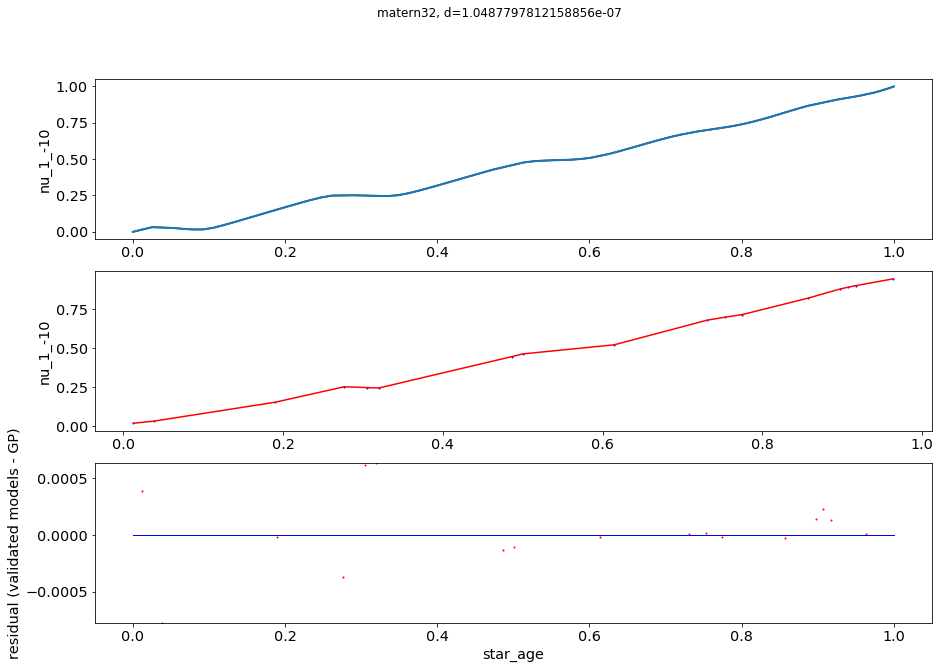

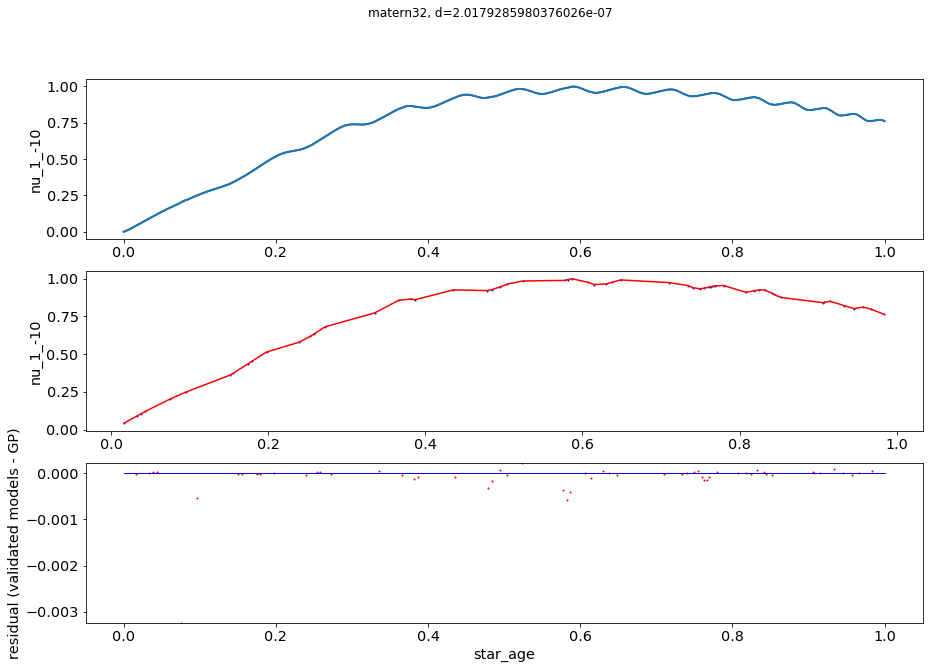

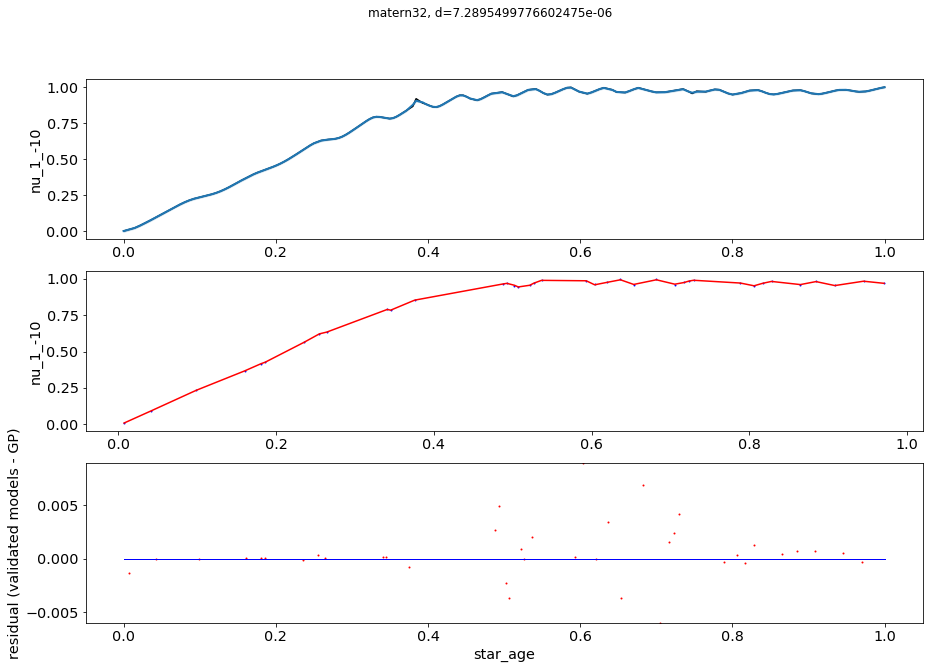

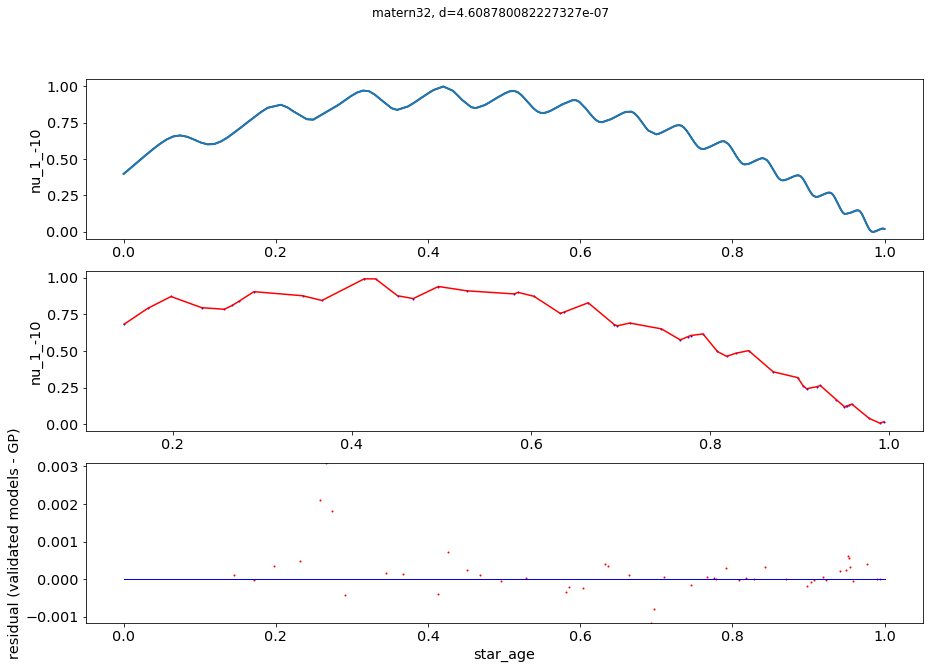

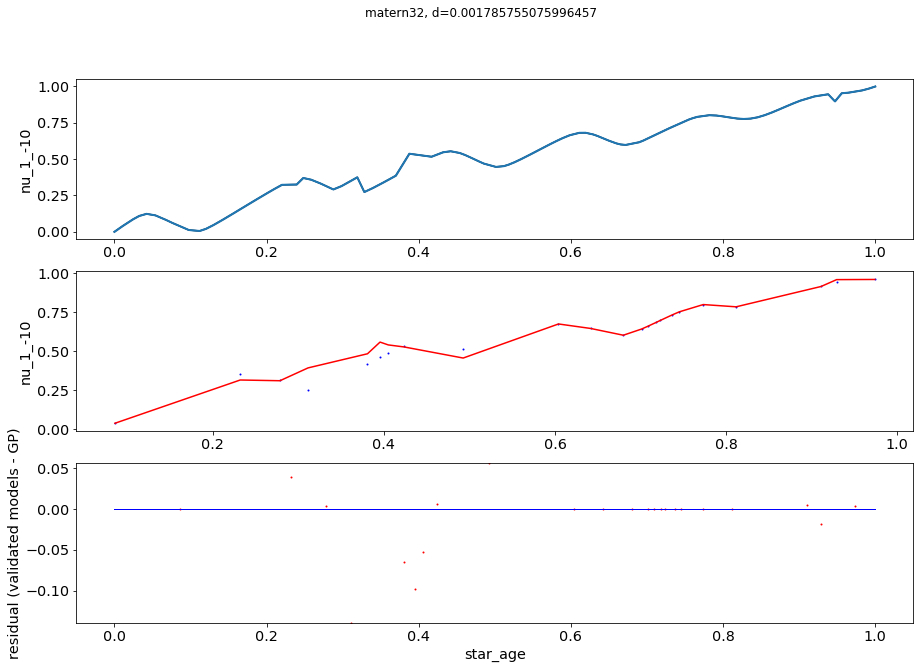

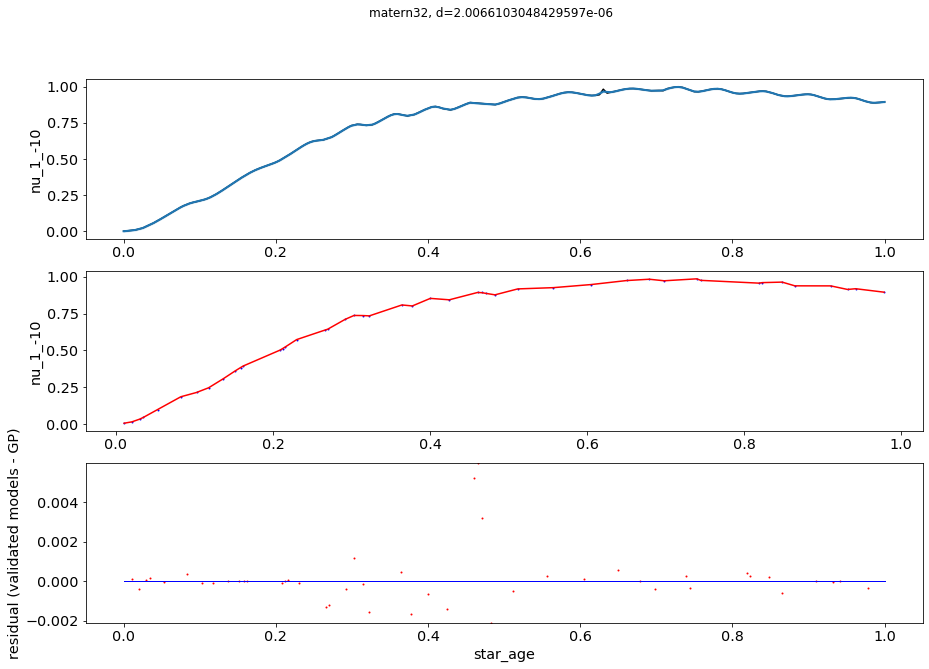

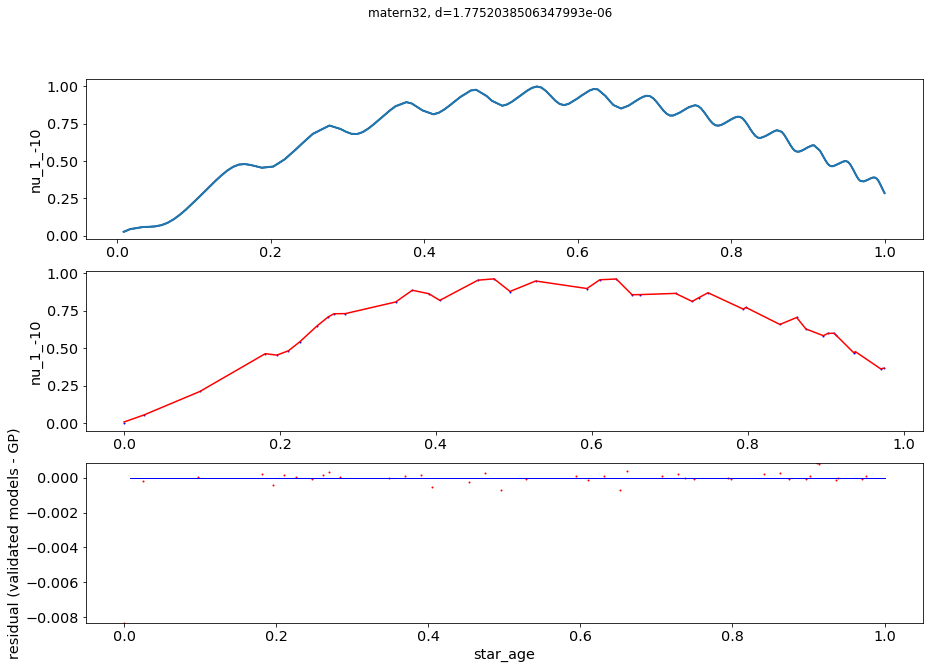

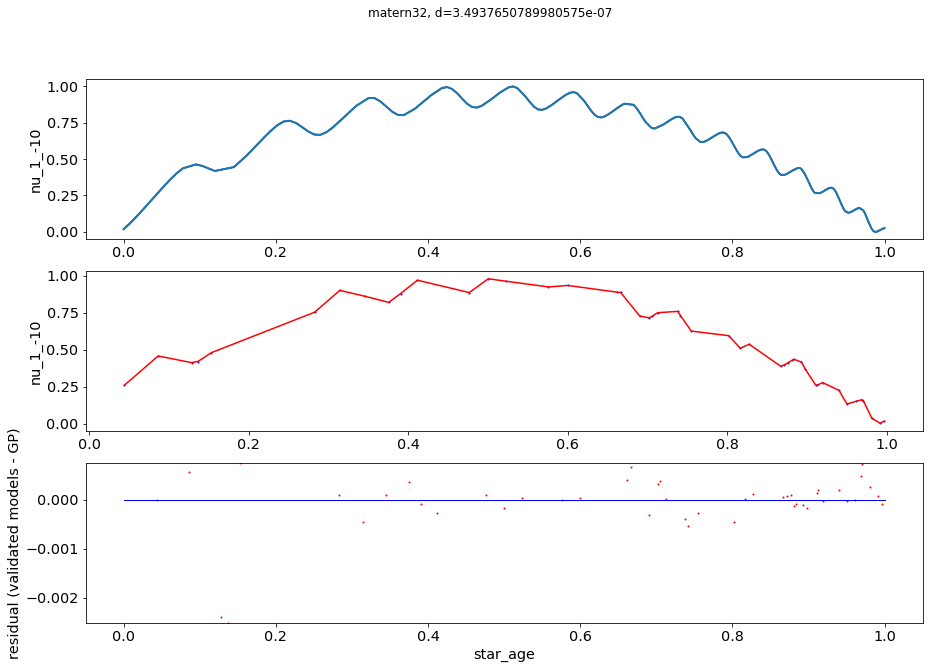

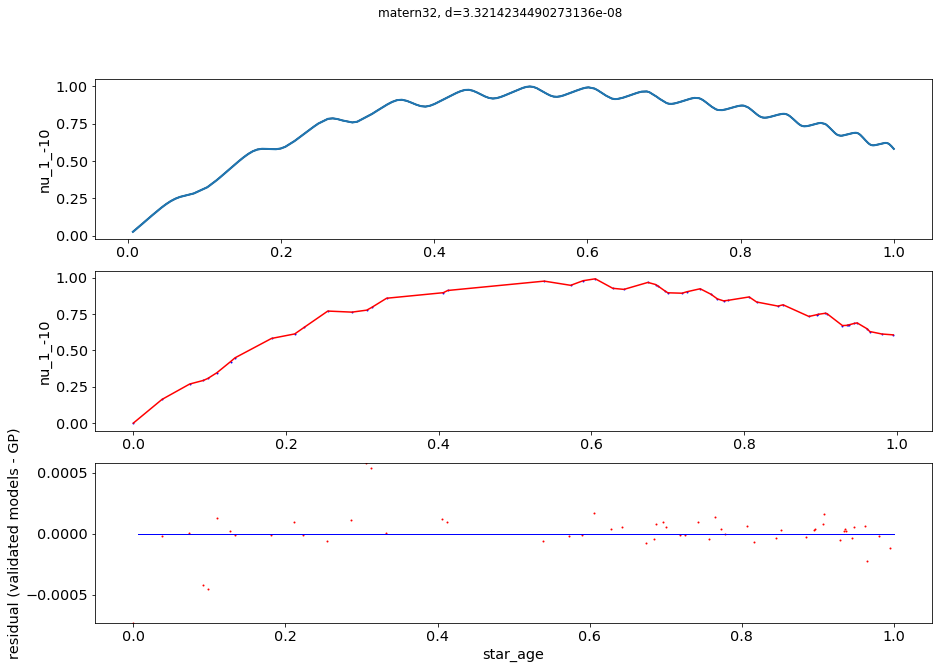

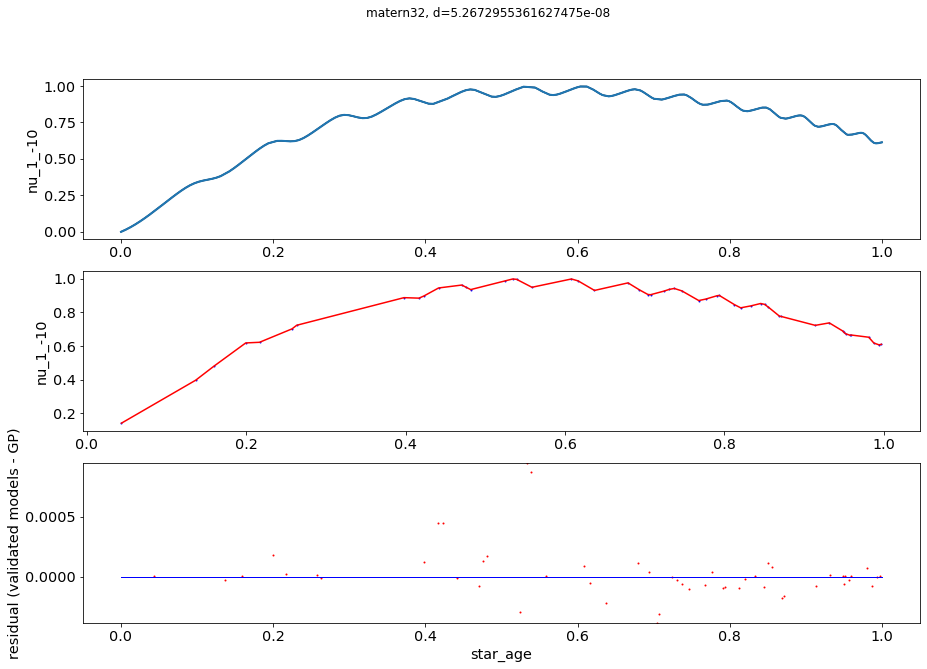

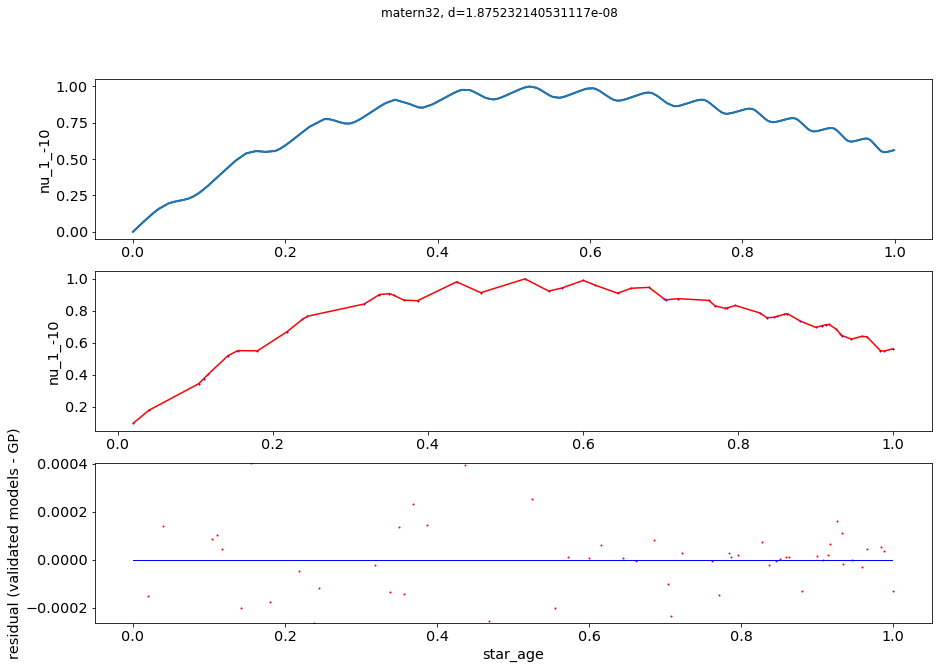

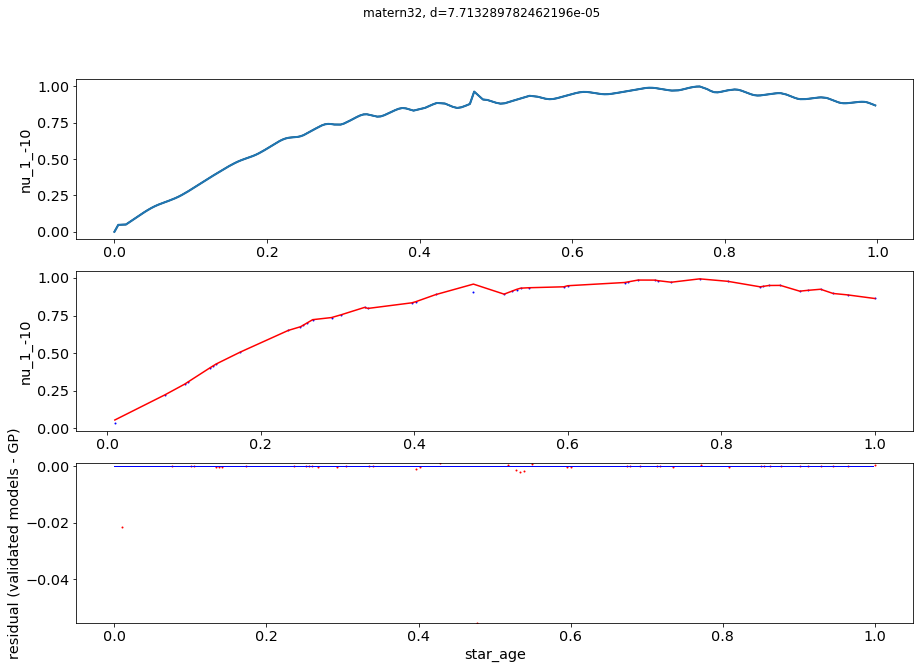

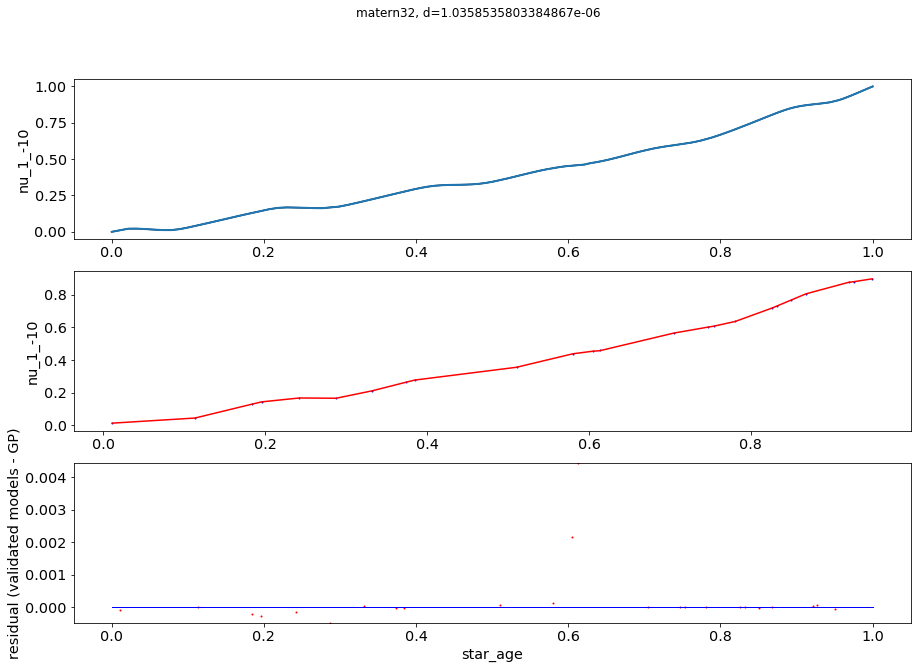

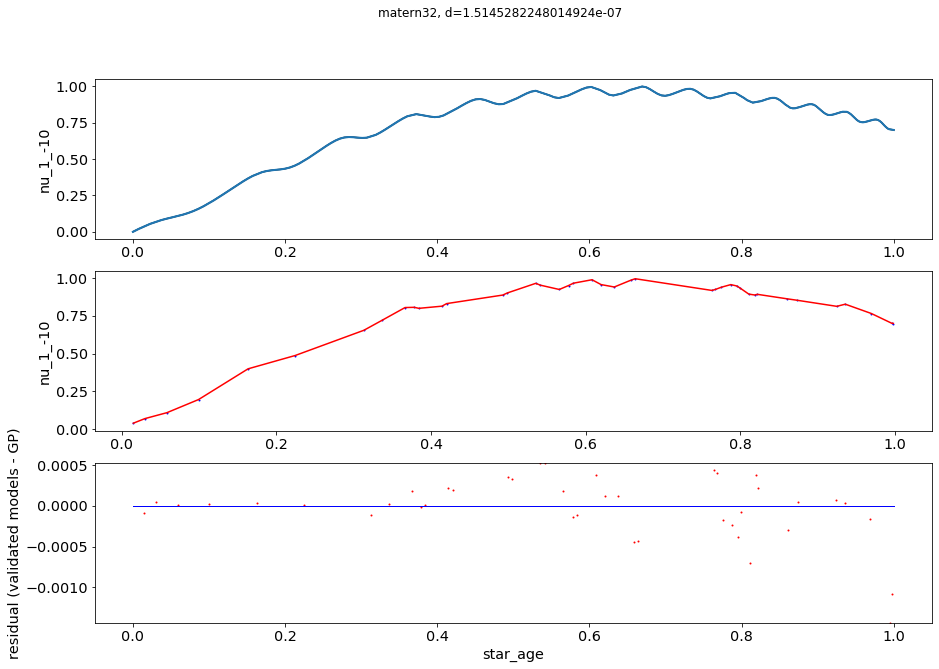

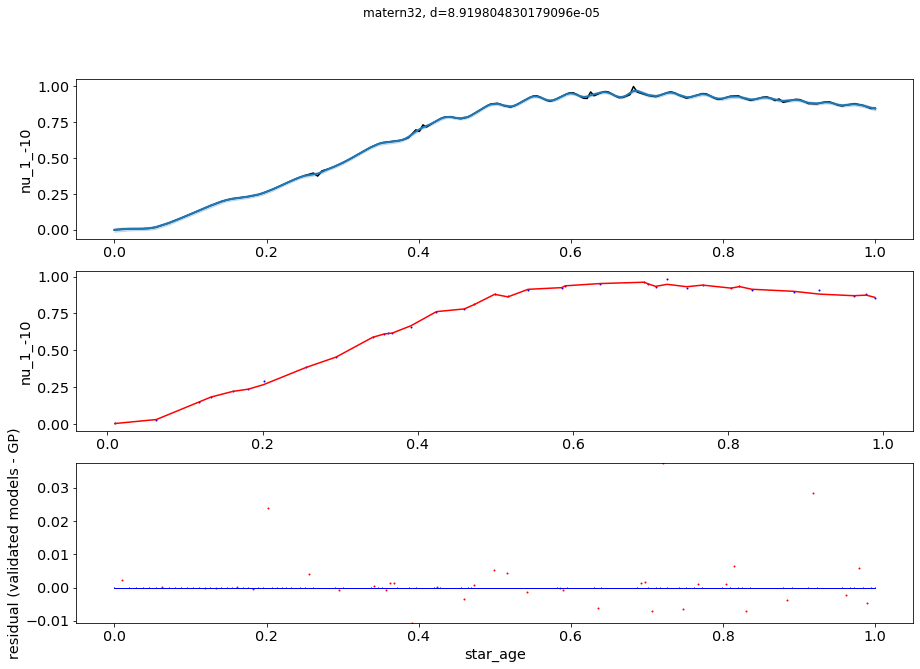

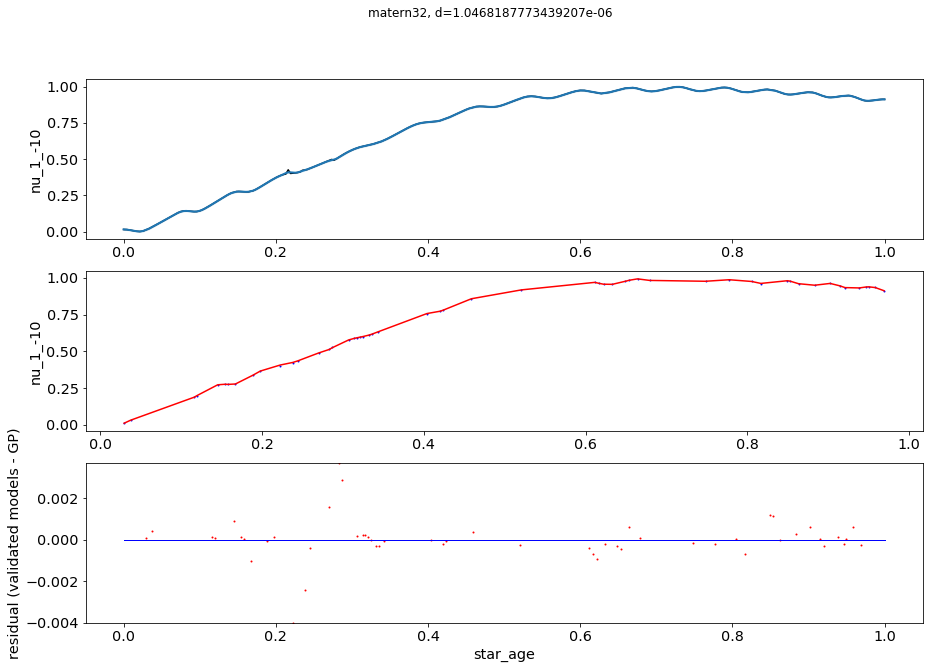

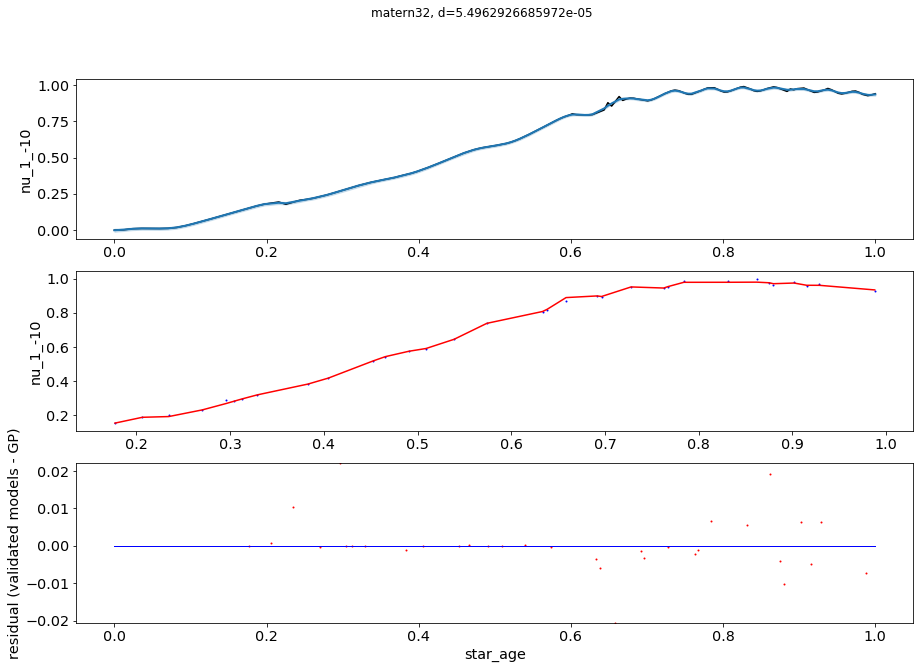

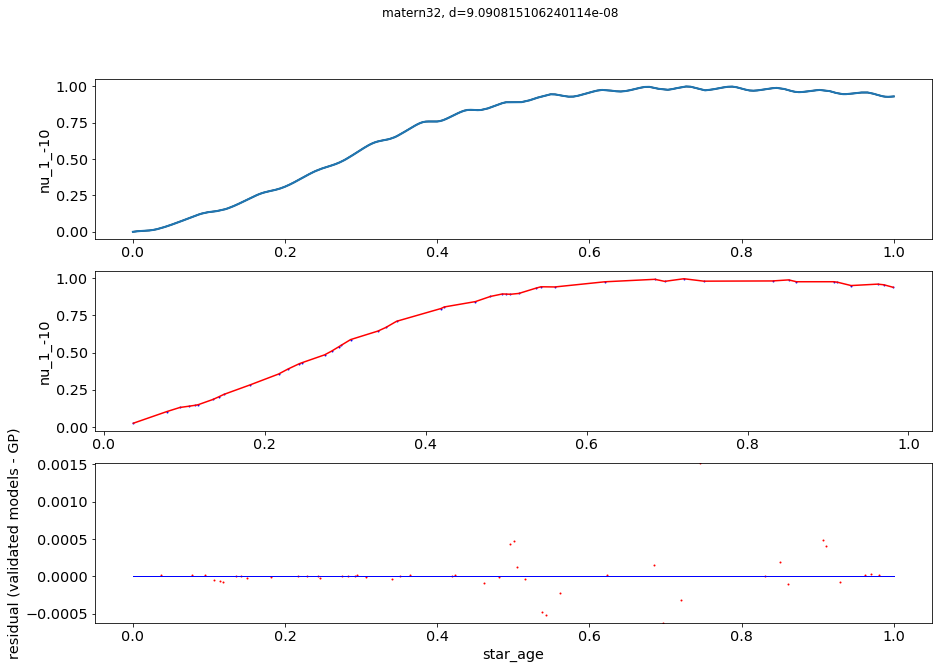

In [44]:
start_time = time.time()

gk_outputs = gk.apply_1d_kernel(condition = '*.csv',
                                      x = 'star_age', y = 'nu_1_-10', x2 = False, 
                                      xlog = False, ylog = False,
                                      xnormalization = True, ynormalization = True,
                                      validation_frac = 0.2,
                                      kernels = kernels, 
                                      combination = False,
                                      iterations = 10,
                                      savemodelprefix = 'GPmodel-nu_1_10-',
                                      printinfo = False, 
                                      figures = True,
                                      savetablename = 'gk_outputs.csv')

print("--- %s seconds ---" % (time.time() - start_time))


In [45]:
gk_outputs.head()

evolutionary_track         x         y     x2   xlog   ylog  \
0  m1.73_feh4.0_MLT1.9_fov0.018  star_age  nu_1_-10  False  False  False   
1  m1.84_feh3.0_MLT1.9_fov0.018  star_age  nu_1_-10  False  False  False   
2  m1.32_feh1.5_MLT1.9_fov0.018  star_age  nu_1_-10  False  False  False   
3  m1.4_feh-2.0_MLT1.9_fov0.018  star_age  nu_1_-10  False  False  False   
4  m1.26_feh3.0_MLT1.9_fov0.018  star_age  nu_1_-10  False  False  False   

                                     xrange  \
0  [2070196279.7534847, 2114565770.9019945]   
1  [1645827028.7394533, 1679588500.4325285]   
2   [4179559279.5614676, 4591972418.631339]   
3  [2654234612.3079786, 2905245632.7188396]   
4    [5543775812.582232, 5935651533.426219]   

                                     yrange xnormalization ynormalization  \
0     [183.5184489399041, 286.408906481023]           True           True   
1  [165.22829572941353, 271.42975429420926]           True           True   
2    [315.4330700454586, 413.7166029160508]           True           True   
3  [241.60214285061323, 398.89233950736013]           True           True   
4  [355.57572571790064, 417.89271379154485]           True           True   

      kname combination  mean_deviation  max_deviation  \
0  matern32       False        0.004664       0.013927   
1  matern32       False        0.000303       0.001344   
2  matern32       False        0.000106       0.001068   
3  matern32       False        0.000506       0.001282   
4  matern32       False        0.000115       0.000444   

                           saveGPmodel                           saveGPdata  
0  m1.73_feh4.0_MLT1.9_fov0.018.gpdict  m1.73_feh4.0_MLT1.9_fov0.018.gpdata  
1  m1.84_feh3.0_MLT1.9_fov0.018.gpdict  m1.84_feh3.0_MLT1.9_fov0.018.gpdata  
2  m1.32_feh1.5_MLT1.9_fov0.018.gpdict  m1.32_feh1.5_MLT1.9_fov0.018.gpdata  
3  m1.4_feh-2.0_MLT1.9_fov0.018.gpdict  m1.4_feh-2.0_MLT1.9_fov0.018.gpdata  
4  m1.26_feh3.0_MLT1.9_fov0.018.gpdict  m1.26_feh3.0_MLT1.9_fov0.018.gpdata

In [46]:
offsets = gk_outputs['mean_deviation']

print(np.mean(offsets), 
      np.min(offsets), 
      np.max(offsets))

0.002260401010038825 9.740716440501446e-05 0.021218475682206077


In [47]:
offsets = gk_outputs['max_deviation']

print(np.mean(offsets), 
      np.min(offsets), 
      np.max(offsets))

0.02157383989667147 0.0004036007430318067 0.45065740412678973


# Step 5 Use models to predict/interpolate 

In [54]:
datadr = '/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/'
savedr = '/Users/litz/Documents/GitHub/GPflow/nu_1_-10/'
gk = seismic_1d_kernel()
gk.set_path(datapath = datadr, savepath = savedr)

Data path is set as/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/
Save path is set as/Users/litz/Documents/GitHub/GPflow/nu_1_-10/


In [55]:
gptablename = savedr + 'GPmodel-nu_1_-10-gk_outputs.csv'
gpdictpath = savedr + 'GPmodel-nu_1_-10-dicts/'
gpdatapath = savedr + 'GPmodel-nu_1_-10-dicts/'

In [57]:
dtype = {'saveGPmodel': object} #, 'saveGPmodel': str, 'saveGPdata': str}

gptable = gk.load_gp_bank(tablename = gptablename, dtype=dtype, gpdictpath = gpdictpath, gpdatapath = gpdatapath)

In [66]:
trackname = 'm1.08_feh2.0_MLT1.9_fov0.018'
tablerow = gptable.loc[gptable['evolutionary_track'] == trackname] 
tablerow.head()


evolutionary_track         x         y     x2   xlog   ylog  \
31  m1.08_feh2.0_MLT1.9_fov0.018  star_age  nu_1_-10  False  False  False   

                                    xrange  \
31  [9366634712.863434, 9826980541.225515]   

                                      yrange  xnormalization  ynormalization  \
31  [354.56021242690883, 400.98019881389763]            True            True   

       kname  combination  mean_deviation  max_deviation  \
31  matern32        False        0.000327       0.002145   

                            saveGPmodel                           saveGPdata  
31  m1.08_feh2.0_MLT1.9_fov0.018.gpdict  m1.08_feh2.0_MLT1.9_fov0.018.gpdata

In [82]:
#x_input need to have same unit with the data grid!
# parameter    unit
#   age       year
#  Teff        K
#  logg       dex
#  radius     solar
#luminosity   solar
#frequency    microHz

x_input = np.linspace(9366634712.863434, 9826980541.225515, num=10000)

track_x, track_y, \
track_x_v, \
track_y_v, track_y_v_e, \
x_new, \
y_new, y_new_e = gk.use_gp_model(model_dict = tablerow['saveGPmodel'].all(), 
                                  model_data = tablerow['saveGPdata'].all(), 
                                  x = tablerow['x'].all(), y = tablerow['y'].all(), 
                                      x2 = tablerow['x2'].all(), 
                                      xlog = tablerow['xlog'].all(), ylog = tablerow['ylog'].all(),
                                      xrange = eval(tablerow['xrange'].all()), 
                                      yrange = eval(tablerow['yrange'].all()),
                                      xnormalization = tablerow['xnormalization'].all(), 
                                      ynormalization = tablerow['ynormalization'].all(),
                                      kernels = [tablerow['kname'].all()], 
                                      combination = tablerow['combination'].all(),
                                      x_input = x_input)




Note that only x_input within xrange will be calculated
/Users/litz/Documents/GitHub/GPflow/nu_1_-10/GPmodel-nu_1_-10-dicts/m1.08_feh2.0_MLT1.9_fov0.018.gpdict


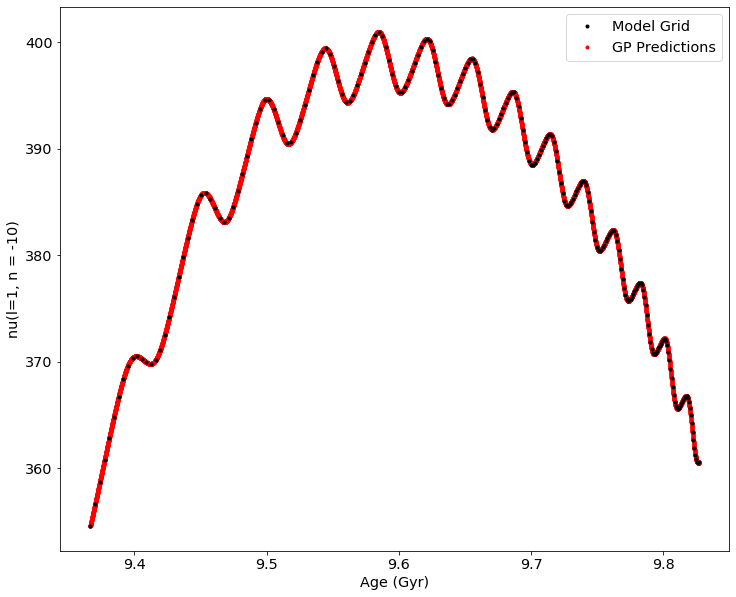

In [83]:
plt.plot(track_x/1.0e9, track_y, 'k.',label='Model Grid')
plt.plot(x_new/1.0e9, y_new, 'r.', label = 'GP Predictions')
plt.plot(track_x/1.0e9, track_y, 'k.')
plt.plot(track_x_v/1.0e9, track_y_v, 'k.')
plt.xlabel('Age (Gyr)')
plt.ylabel(r'nu(l=1, n = -10)')
plt.legend()

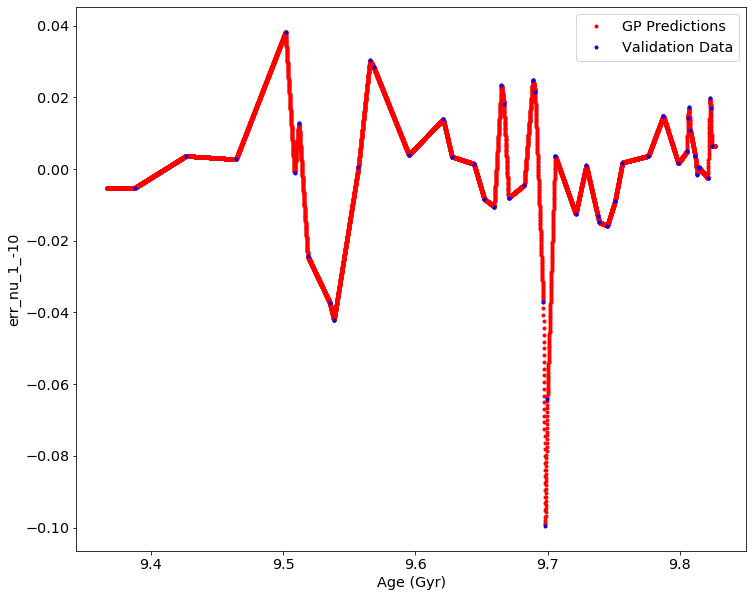

In [85]:
plt.plot(x_new/1.e9, y_new_e, 'r.',label = 'GP Predictions')
plt.plot(track_x_v/1.e9, track_y_v_e, 'b.', label = 'Validation Data')
plt.xlabel('Age (Gyr)')
plt.ylabel(r'err_nu_1_-10')
plt.legend()